# Import 

In [1]:
%matplotlib inline

import os
import math
from glob import glob
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFilter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from fannet import FANnet
from style_encoder import StyleEncoder
from data_loader import make_data_loader

# Parameter

In [2]:
device = 'cuda:0'
image_size = 64
batch_size = 128

# model_path = './weight/log23_S2074_cfg_step_100000.pth' # w/o style encoder, 2074font, Aのみ
# model_path = './weight/log24_S2074_cfg_step_20000.pth' # w/ style encoder, 2074font, Aのみ
# model_path = './weight/log24_S2074_cfg_step_40000.pth' # w/ style encoder, 2074font, Aのみ
# model_path = './weight/log25_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ
# model_path = './weight/log26_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下左右
# model_path = './weight/log27_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下
# model_path = './weight/log28_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下, 拡大縮小
# model_path = './weight/log29_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下左右, 拡大縮小
# model_path = './weight/log33_fannet_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,
# model_path = './weight/log34_fannet2_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# style に文字, fannet
# model_path = './weight/log33_fannet_step_320000.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# 平均スタイル，fannet
model_path = './weight/log36_fannet_step_180000.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# 平均スタイル, fannet_retrain, dataloaderのencoder要確認
# model_path = './weight/log38_fannet_retrain_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

encoder_name = model_path.split('_')[1]

# encoder_path = './weight/style_encoder.pth'
encoder_path = f'./weight/style_encoder_{encoder_name}.pth'
# encoder_path = f'./weight/style_encoder_{encoder_name}_retrain.pth'

seed = 7777
da_rate = 0.
channels = 1
unet_dim = 128 # 32 or 128
num_class = 26
timesteps = 1000
cond_drop_prob = 0.1
dataset_name = 'myfonts' # 'myfonts' or 'google_fonts'
style_encoder_zdim = 128
use_style_encoder = True
unet_dim_mults = (1, 2, 4, 8,)
# num_style = int(model_path.split('/')[-1].split('_')[1][1:])

freeze_seed(seed)

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる
log_one_minus_alphas_cumprod = torch.log(1. - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, style, t, t_index, class_scale=3., style_scale=3., rescaled_phi=0.):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, style, shape, class_scale=3., style_scale=3., rescaled_phi=0.):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, classes, style, t, i, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, classes, style, image_size, batch_size=16, channels=3, class_scale=1., style_scale=3., rescaled_phi=0.):
    return p_sample_loop(model, classes, style, shape=(batch_size, channels, image_size, image_size), class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

@torch.no_grad()
def ddim_sample(model, classes, style, class_scale=1., style_scale=1.):
    batch, total_timesteps, sampling_timesteps, eta = style.shape[0], timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    img = torch.randn((batch, 1, image_size, image_size), device = device)

    x_start = None

    for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
        t = torch.full((batch,), time, device=device, dtype=torch.long)
        pred_noise = model.forward_with_cond_scale(img, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)
        x_start  = extract(sqrt_recip_alphas_cumprod, t, img.shape) * img -\
                        extract(sqrt_recipm1_alphas_cumprod, t, img.shape) * pred_noise

        if time_next < 0:
            img = x_start
            continue

        alpha = alphas_cumprod[time]
        alpha_next = alphas_cumprod[time_next]

        sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
        c = (1 - alpha_next - sigma ** 2).sqrt()

        noise = torch.randn_like(img)

        img = x_start * alpha_next.sqrt() + \
                c * pred_noise + \
                sigma * noise

    return img

@torch.no_grad()
def p_sample_noise_interpolate(model, x, style1, style2, t, style_scale, alpha=0.5):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predict noise
    style1_noise = model.forward_with_cond_scale(x, t, style1, style_scale=style_scale, rescaled_phi=0.)
    style2_noise = model.forward_with_cond_scale(x, t, style2, style_scale=style_scale, rescaled_phi=0.)

    # style interpolation
    pred_noise = alpha * style1_noise + (1 - alpha) * style2_noise

    # sampling
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_emb_interpolate(model, x, style1, style2, t, style_scale=3., alpha=0.5):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    cond_logits = model.forward_with_emb_interpolate(x, t, style1, style2, alpha=alpha, style_drop_prob=0.)
    nocond_logits = model.forward_with_emb_interpolate(x, t, style1, style2, alpha=alpha, style_drop_prob=1.)
    pred_noise = nocond_logits + style_scale*(cond_logits - nocond_logits)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# Load data

In [3]:
margin = 5 # 5で学習
dataloader = make_data_loader(batch_size, image_size, num_class, encoder_name, device, dataset_name, da_rate, margin=margin)
d = dataloader['train'].dataset
d_val = dataloader['val'].dataset
d_test = dataloader['test'].dataset

DATASET NAME IS myfonts
STYLE ENCODER IS fannet
TRAIN SIZE: 362388
VAL SIZE: 45084
TEST SIZE: 45240


# Load trained model

In [4]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_class=num_class,
    cond_drop_prob=cond_drop_prob,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'ok {model_path}')

ok ./weight/log36_fannet_step_180000.pth


# style encoder の特徴の可視化

TRAIN SIZE: 362388
VALID SIZE: 45084
TEST SIZE: 45240
[0.33906509 0.09424054 0.05151445]


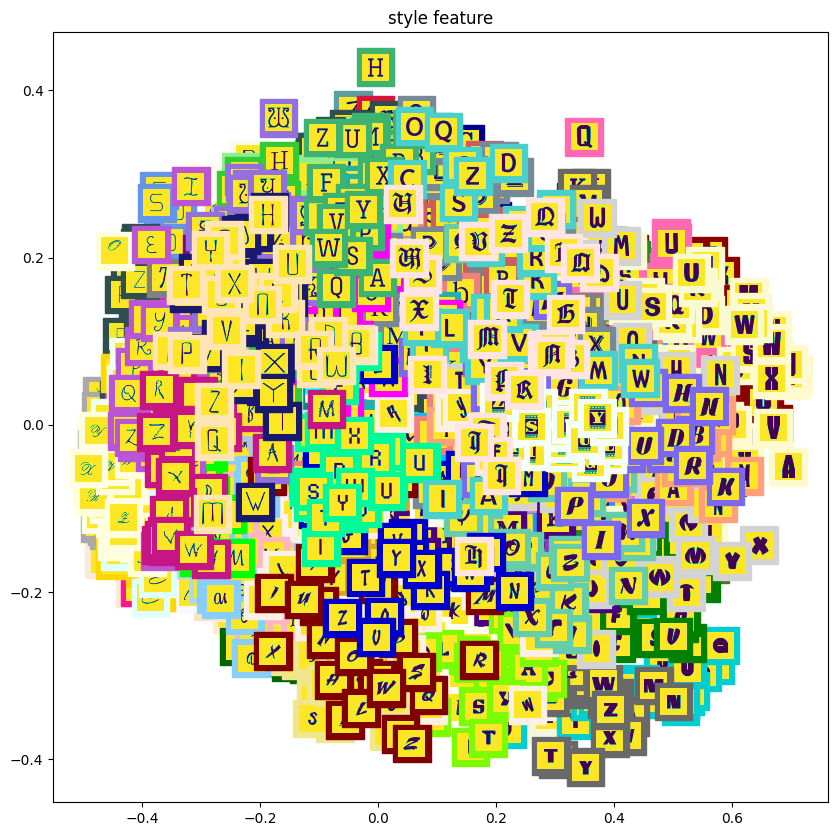

In [6]:
model_name = 'fannet'
if model_name == 'fannet':
    model = FANnet(num_class).to(device)
elif model_name == 'fannet2':
    model = StyleEncoder(num_class).to(device)

model.load_state_dict(torch.load(f'weight/style_encoder_{model_name}_retrain.pth', map_location=device))
model.eval()

from train_fannet import make_data_loader as _make_data_loader
_data = _make_data_loader(16, num_class, image_size)['train']

features = []
imgs = []
color_map = list(matplotlib.colors.CSS4_COLORS.values())
color = []
with torch.no_grad():
    for i in range(0, 26*100):
        img = _data.dataset[i][0]
        imgs.append(img)
        img = img.to(device)
        style = model.style_encode(img.unsqueeze(0))
        features.append(style.cpu().detach())
        color.append(color_map[i//26])

features = torch.cat(features, dim=0)
imgs = torch.cat(imgs, dim=0).squeeze(1)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
imscatter(X_reduced[:, 0], X_reduced[:, 1], imgs, _ax=ax, zoom=0.3,color=color)
ax.plot(X_reduced[:, 0], X_reduced[:, 1], 'ko', alpha=0.)
ax.set_title('style feature')
plt.savefig(f'result/style_encoder_{model_name}_feature_A-Z_retrain.png')
plt.show()

# L1

In [ ]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")

for scale in [1., 3., 5., 7.]:
    style_scale = scale
    rescaled_phi = 0.

    loss = nn.L1Loss()
    total_loss = 0.

    for gt, s in dataloader:
        gt = gt.to(device)
        s = s.to(device)
        output = sample(model, s, image_size=image_size, batch_size=gt.size(0), channels=channels,
                        style_scale=style_scale, rescaled_phi=rescaled_phi, is_ddim_sampling=False)

        total_loss += loss(torch.clamp(output, min=-1., max=1.), gt).item() * gt.size(0)
        break

    total_loss /= len(dataloader.dataset)

    # eval.txt は全モデルで共通
    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

# condition 指定して生成

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

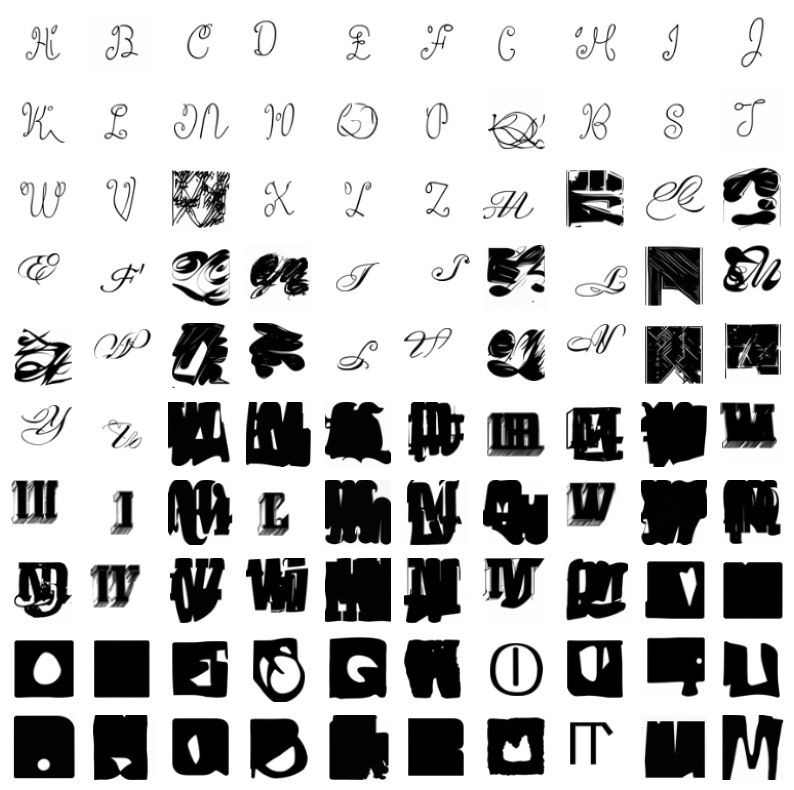

In [6]:
class_scale = 3.
rescaled_phi = 0.
ddim_sampling = True

scale_list = [3.]

for ss in scale_list:
    if ddim_sampling == False:
        save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{dataset_name}_s_{ss}_c_{class_scale}.png"
    else:
        save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{dataset_name}_ddim_s_{ss}_c_{class_scale}.png"

    b = 100
    style = torch.cat([d[i][1].unsqueeze(0) for i in range(b)]).to(device)
    classes = torch.tensor([d[i][2] for i in range(b)]).to(device)
    if ddim_sampling == False:
        samples = sample(model, classes, style, image_size, batch_size=b, channels=channels,
                        class_scale=class_scale, style_scale=ss, rescaled_phi=rescaled_phi)
    else:
        samples = ddim_sample(model, classes, style, class_scale=class_scale, style_scale=ss)

    # show images
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        x = i // 10
        y = i % 10
        ax[x, y].axis("off")
        ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

    plt.savefig(save_path1)
    plt.show()


# GT

## google font

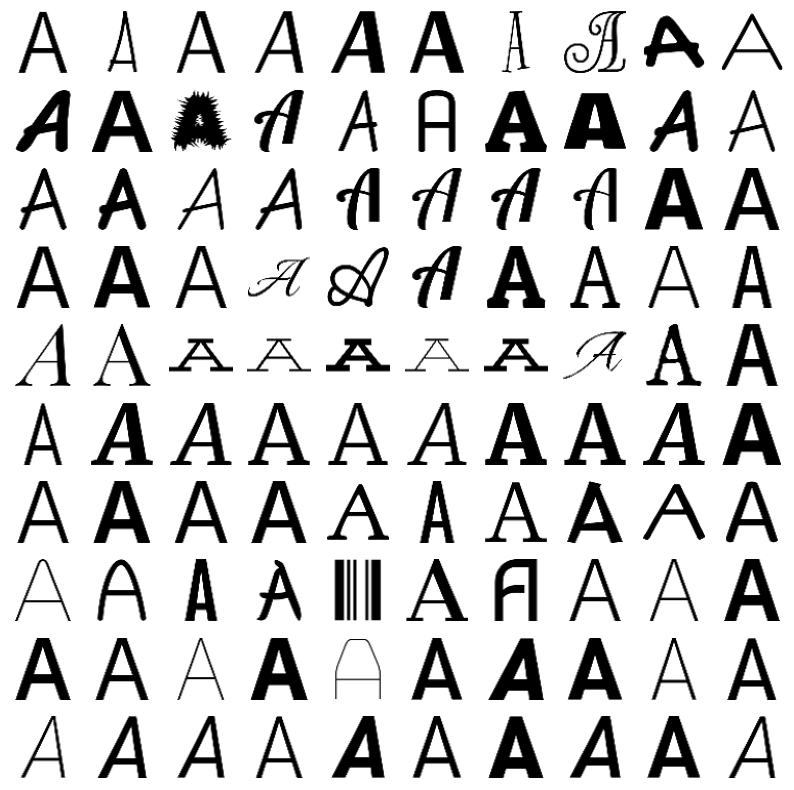

In [ ]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[i][0][0], cmap='gray')

## myfonts

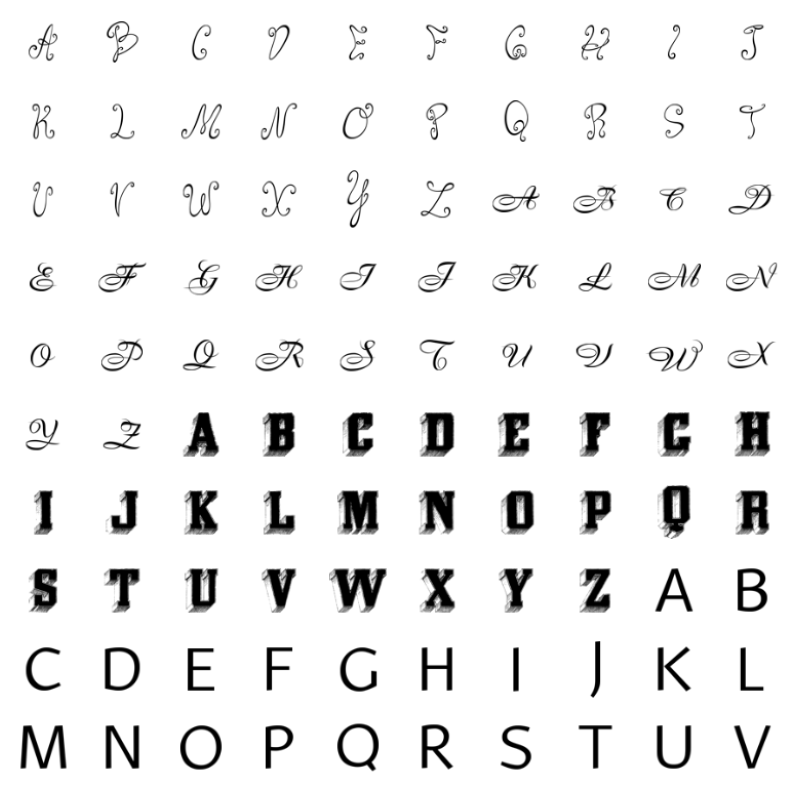

In [4]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[i][0][0], cmap='gray')

In [ ]:
data_type = 'train' # 'train' or 'val' or 'test'

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for start_i in range(0, 1000, 100):
    # start_i = 0
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(100):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].set_title(f'{start_i+i}')
        ax[i//10, i%10].imshow(data[26*(start_i+i)][0][0], cmap='gray')

    plt.tight_layout()
    plt.savefig(f"result/{dataset_name}_{data_type}_from_{start_i}_to_{start_i+100}.png")
    # plt.show()

# ノイズの内挿

## Bold - Light

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

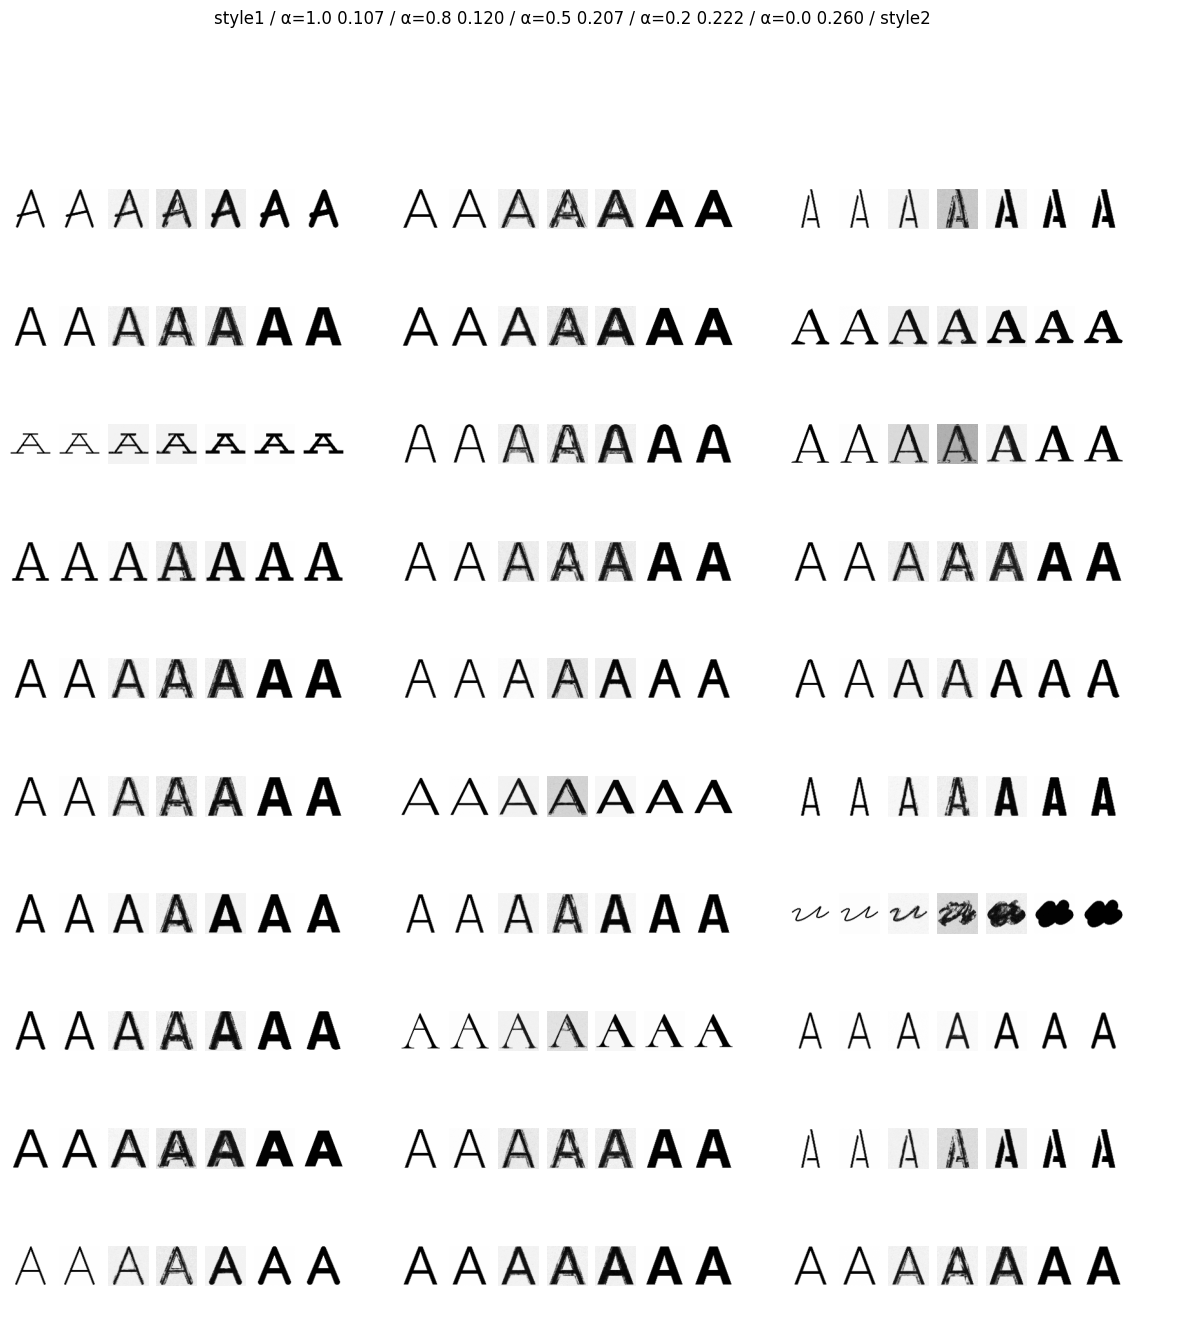

In [ ]:
############ class 非対応 ############
data_dict = {}
weight_cnt = {}

# 学習データ（1000データ）からfontfのidを取得
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
style_i = 0
for data_type in ['train']:
    data_type_df = df[df['data_type'] == data_type]

    for i in range(len(data_type_df)):
        if style_i >= num_style: break
        p = os.path.join('../font2img/image', data_type_df.loc[i, 'font'])
        if os.path.isdir(p) == False: continue

        if '-' in data_type_df.loc[i, 'font']:
            fontfamily = data_type_df.loc[i, 'font'].split('-')[0]
            weight = data_type_df.loc[i, 'font'].split('-')[1]
            if fontfamily in data_dict:
                data_dict[fontfamily][weight] = style_i
            else:
                data_dict[fontfamily] = {weight: style_i}

            if weight in weight_cnt:
                weight_cnt[weight] += 1
            else:
                weight_cnt[weight] = 1

        style_i += 1

# print(data_dict)
# print(weight_cnt)

# 3種類のweightを持つfontのみを抽出
pair_data_list = []
for font, weights in data_dict.items():
    if 'Bold' in weights and 'Regular' in weights and 'Light' in weights:
        pair_data_list.append({'Bold': weights['Bold'], 'Regular': weights['Regular'], 'Light': weights['Light']})

# print(pair_data_list)

# 内挿
style_scale = 3.
b = 30
img = torch.randn((b, channels, image_size, image_size), device=device)
style1 = torch.tensor([pair_data_list[i]['Light'] for i in range(b)], device=device, dtype=torch.long)
style2 = torch.tensor([pair_data_list[i]['Bold'] for i in range(b)], device=device, dtype=torch.long)
if use_style_encoder == True:
    style1 = torch.cat([d[style1[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2[i]][1].unsqueeze(0) for i in range(b)]).to(device)

gt = torch.cat([d[pair_data_list[i]['Regular']][0] for i in range(b)]).unsqueeze(1).to(device)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_noise_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

loss_alpha = {}
for a in img_alpha.keys():
    loss_alpha[a] = nn.L1Loss()(torch.clamp(img_alpha[a], min=-1., max=1.), gt)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[pair_data_list[i]['Light']][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[pair_data_list[i]['Bold']][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} {loss_alpha[a] :.3f} / '
title += 'style2'

fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale{style_scale}.png")
plt.show()


## random

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

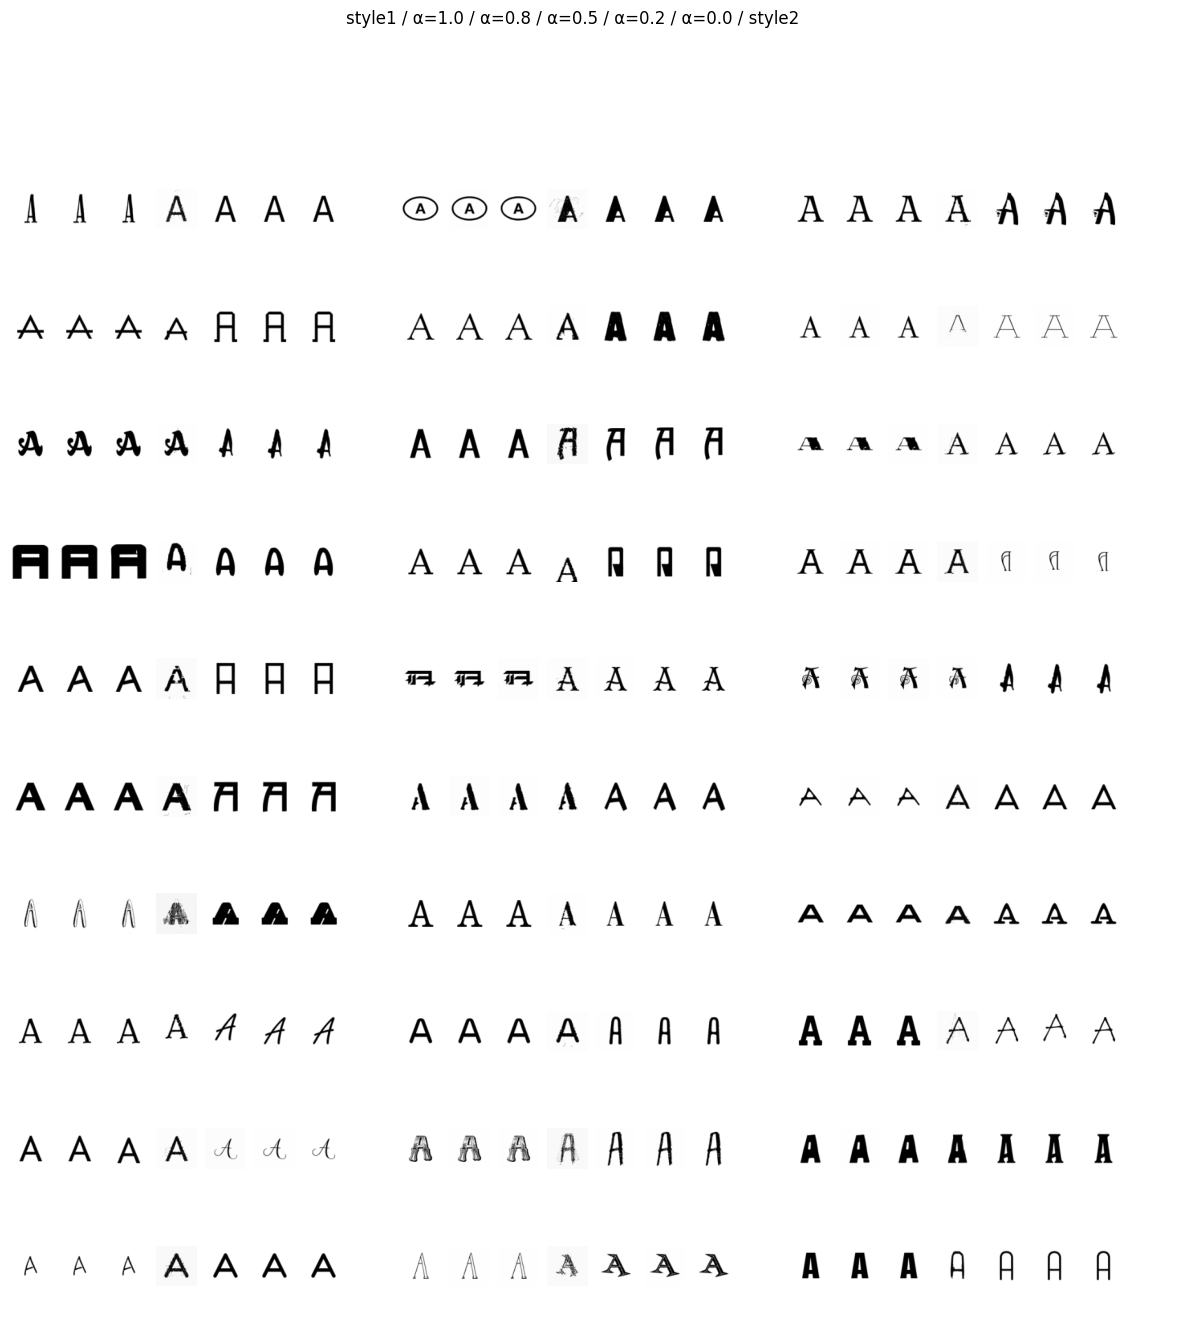

In [ ]:
############ class 非対応 ############

# いろんなフォントの内挿
style_scale = 3.
b = 30
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.randint(0, num_style, (b,))
style2_id = torch.randint(0, num_style, (b,))

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_noise_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2_id[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale_{style_scale}_id_{interpolation_seed}.png")

## Pick

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

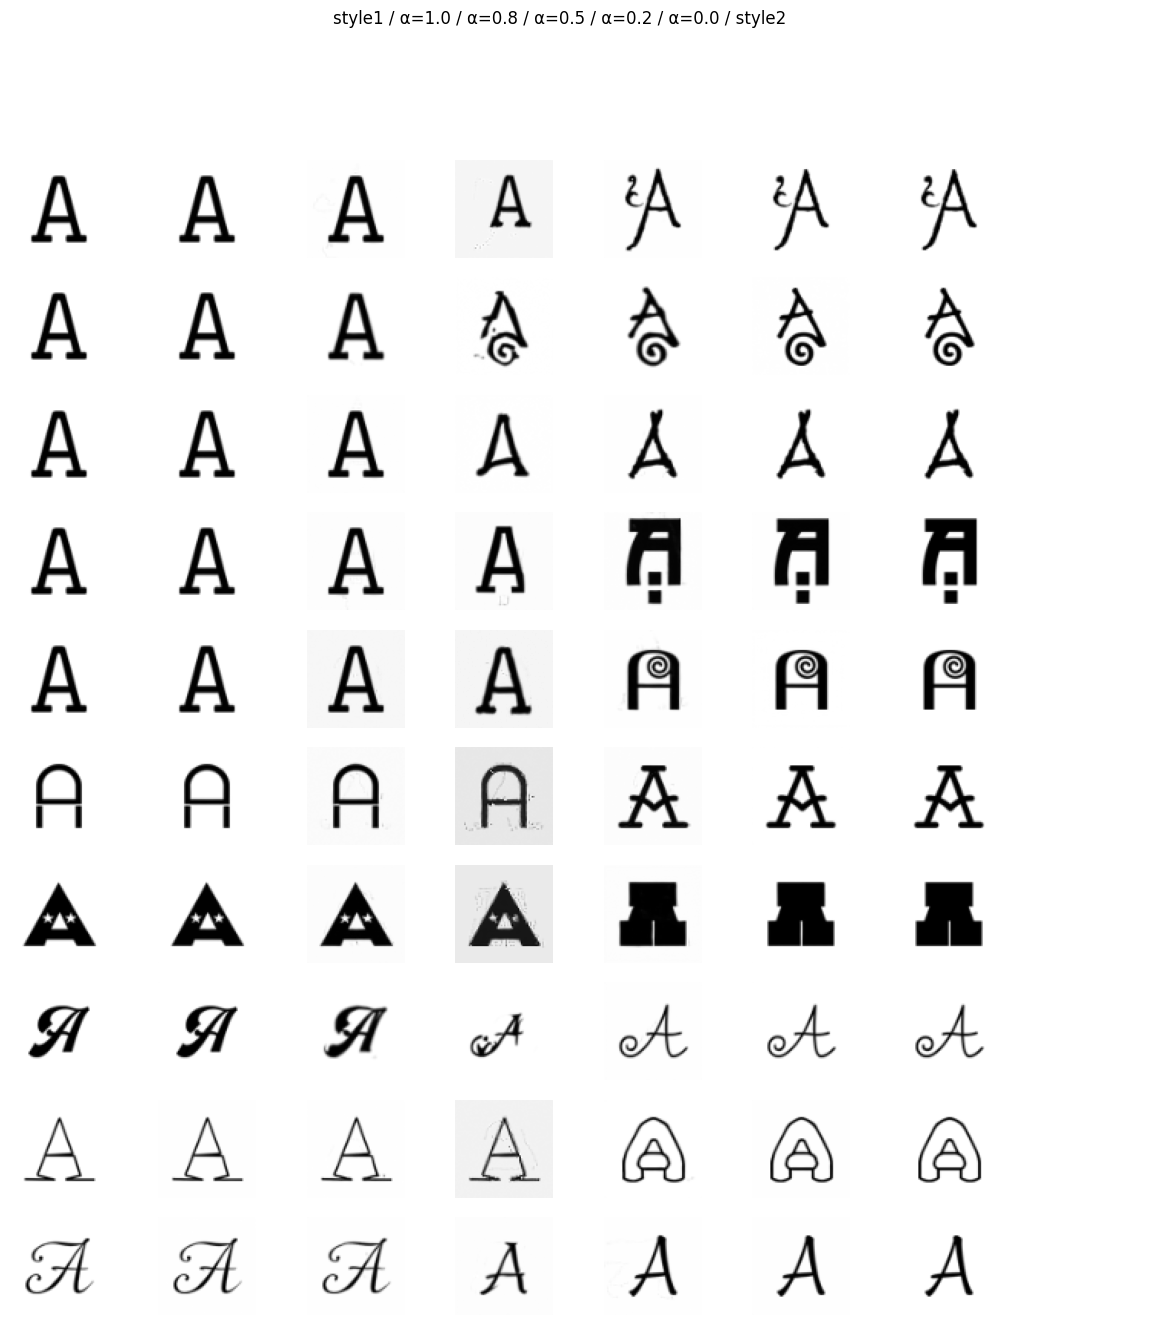

In [ ]:
############ class 非対応 ############

# 自分で用意したフォントの内挿
style_scale = 5.
pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
            (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.tensor([pair_id[i][0] for i in range(len(pair_id))], device=device, dtype=torch.long)
style2_id = torch.tensor([pair_id[i][1] for i in range(len(pair_id))], device=device, dtype=torch.long)
b = min(30, style1_id.size(0))

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_noise_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*((b+9)//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2_id[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale_{style_scale}.png")

## いろんなα

0it [00:00, ?it/s]

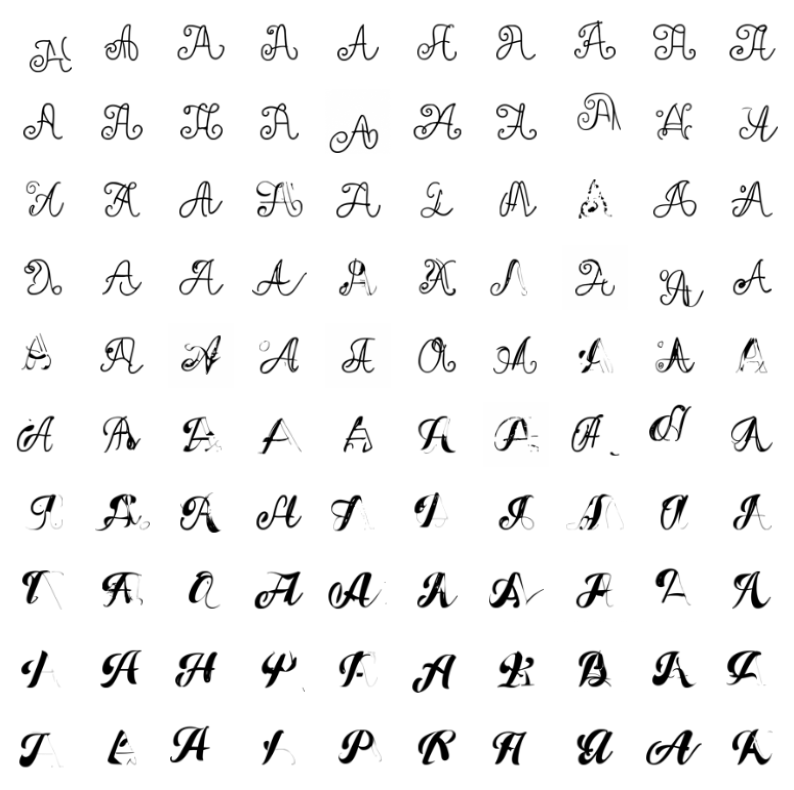

0it [00:00, ?it/s]

In [6]:
style1_id = 91 # 222, 91
style2_id = 184 # 406, 494, 184, 275
style_scale = 3.
class_scale = 3.
char = 'A'
num_split = 100
interpolation_seed = 1

freeze_seed(interpolation_seed)

pair_id = [(222, 275), (28, 40), (185, 198), (274, 284)]
# pair_id = [(275, 185), (284, 249), ]


for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([d[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([d[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    with torch.no_grad():
        for t_index in tqdm(reversed(range(0, timesteps))):
            t = torch.full((b,), t_index, device=device, dtype=torch.long)
            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            # predict noise
            style1_noise = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)
            style2_noise = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_index == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                _noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * _noise

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

### ddim

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

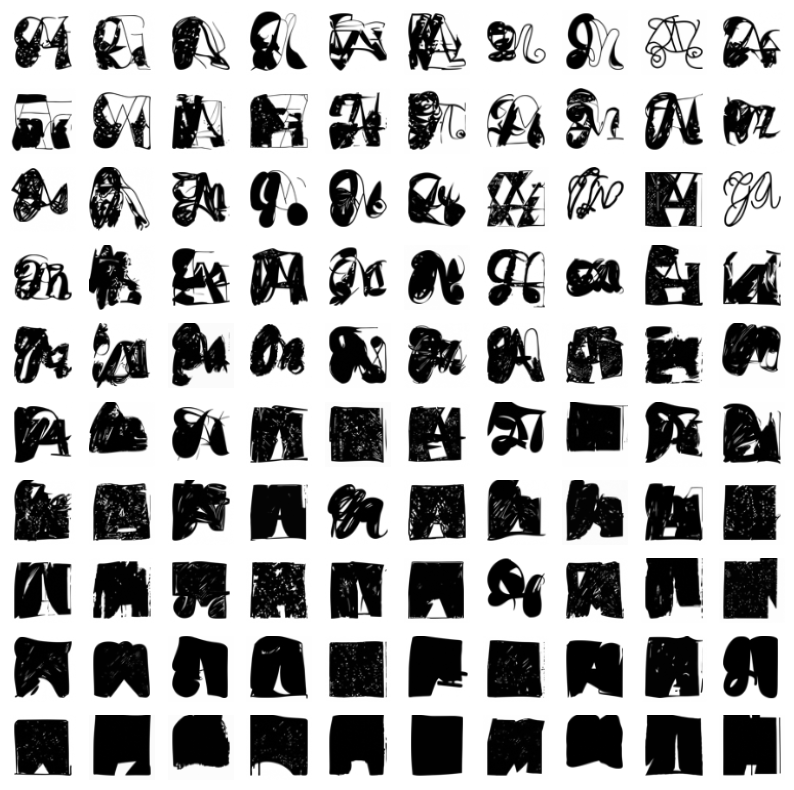

In [8]:
style_scale = 3.
class_scale = 3.
char = 'A'
num_split = 100
interpolation_seed = 1
data_type = 'train' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Noise'

freeze_seed(interpolation_seed)

# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184)]
pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
            (284, 249), (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
            (91, 406), (80, 471), ]

# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]

# google font
# pair_id = [(44,45), (90, 91), (20, 21)]

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)

            style1_noise = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)
            style2_noise = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + \
                    c * pred_noise + \
                    sigma * noise


    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_ddim_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(a) for a in alphas]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

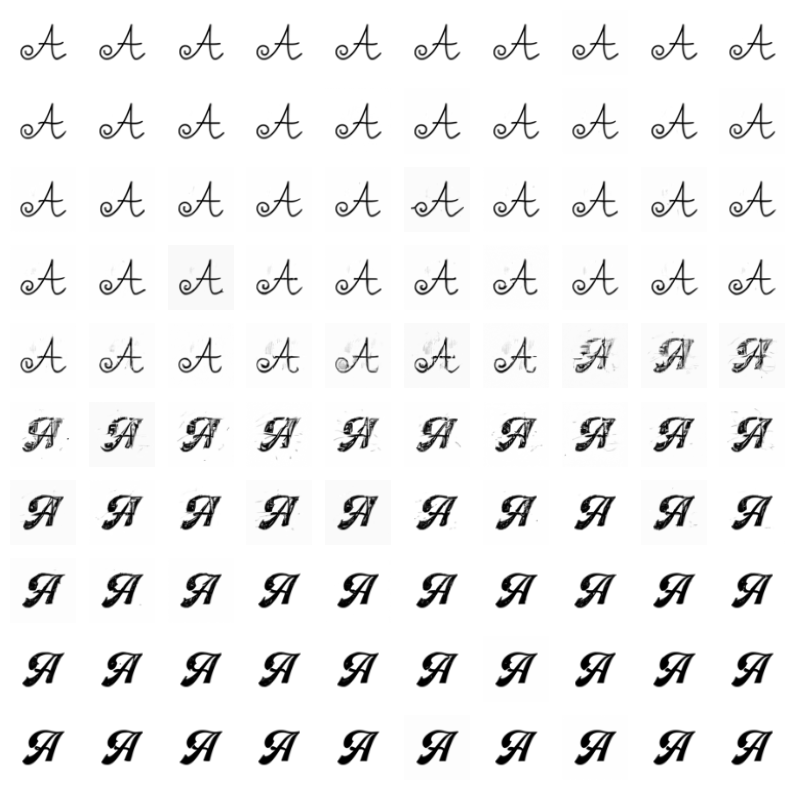

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

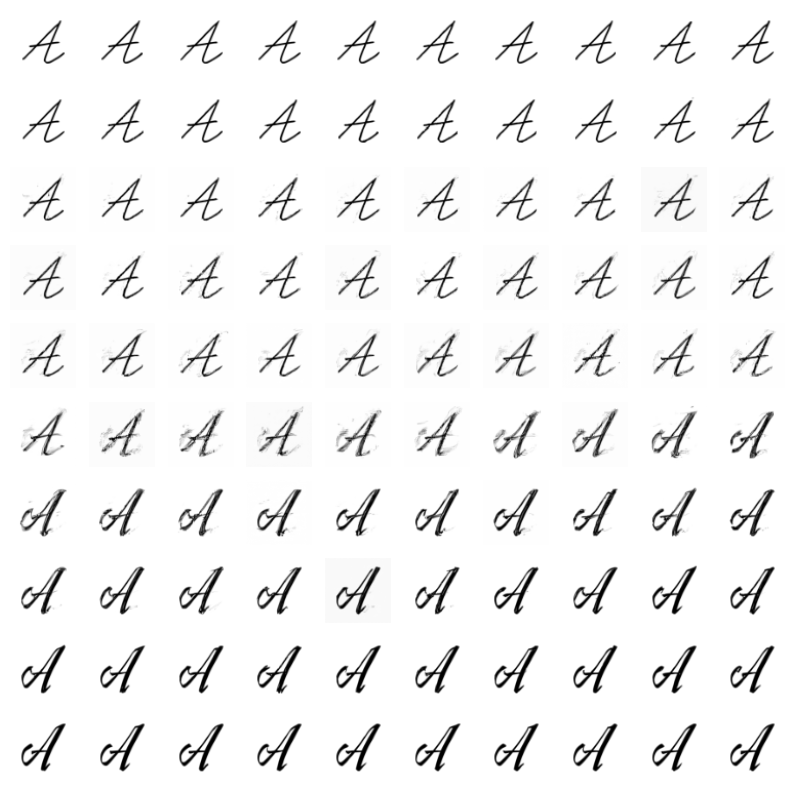

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

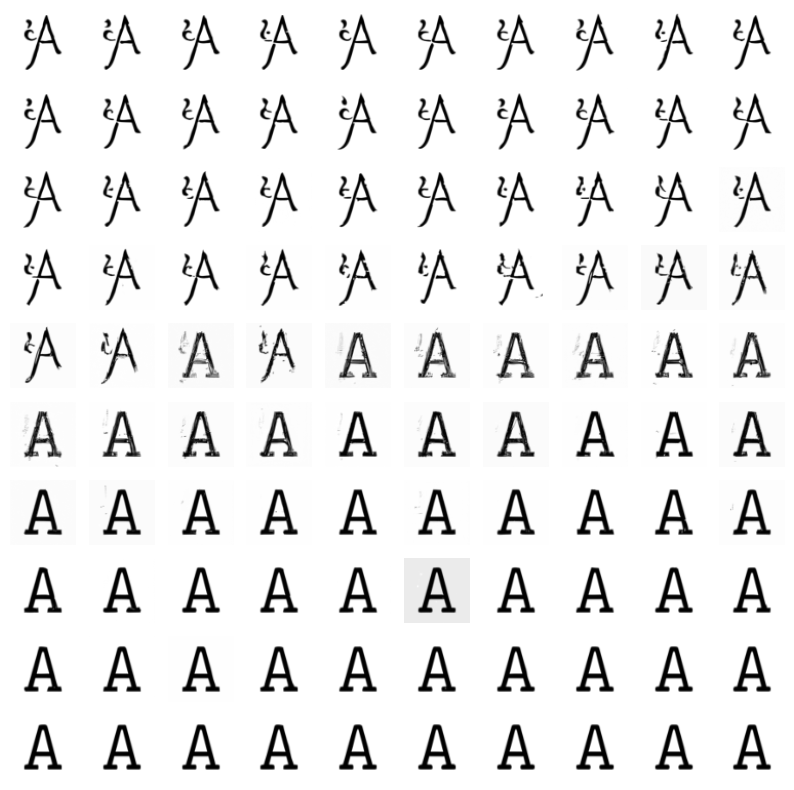

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

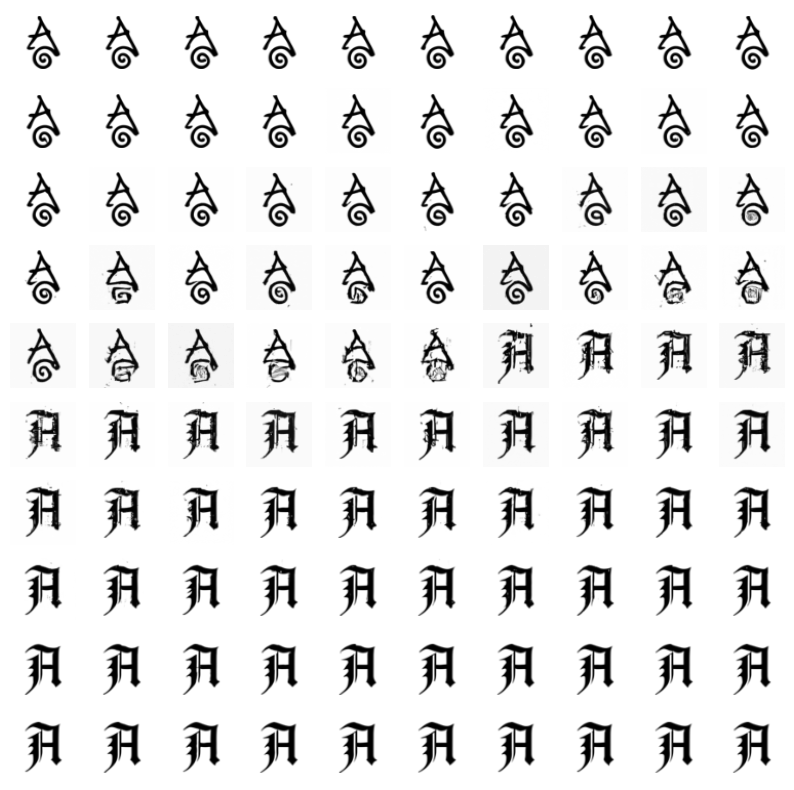

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

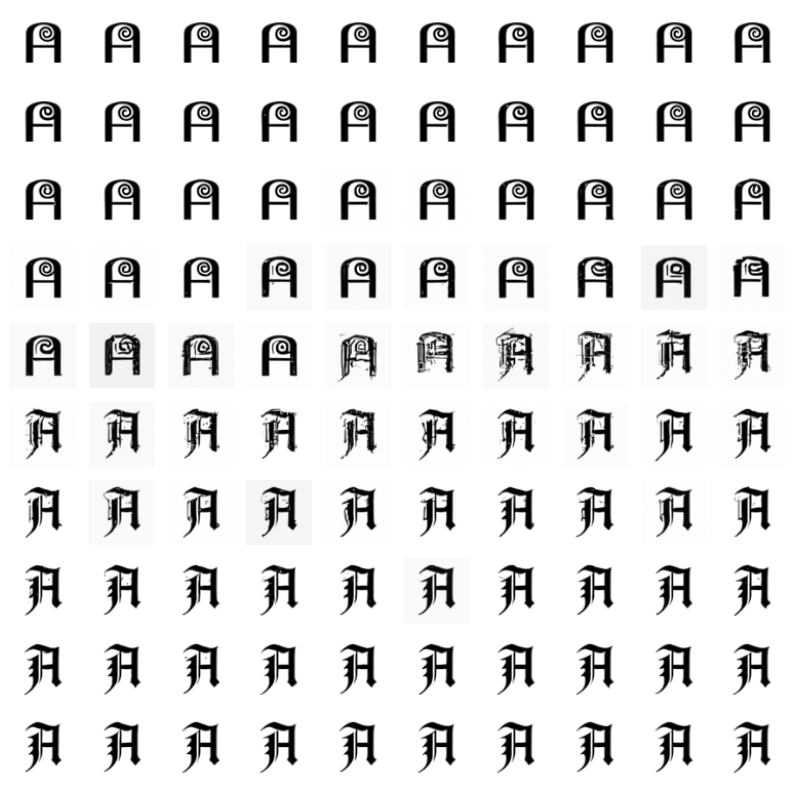

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

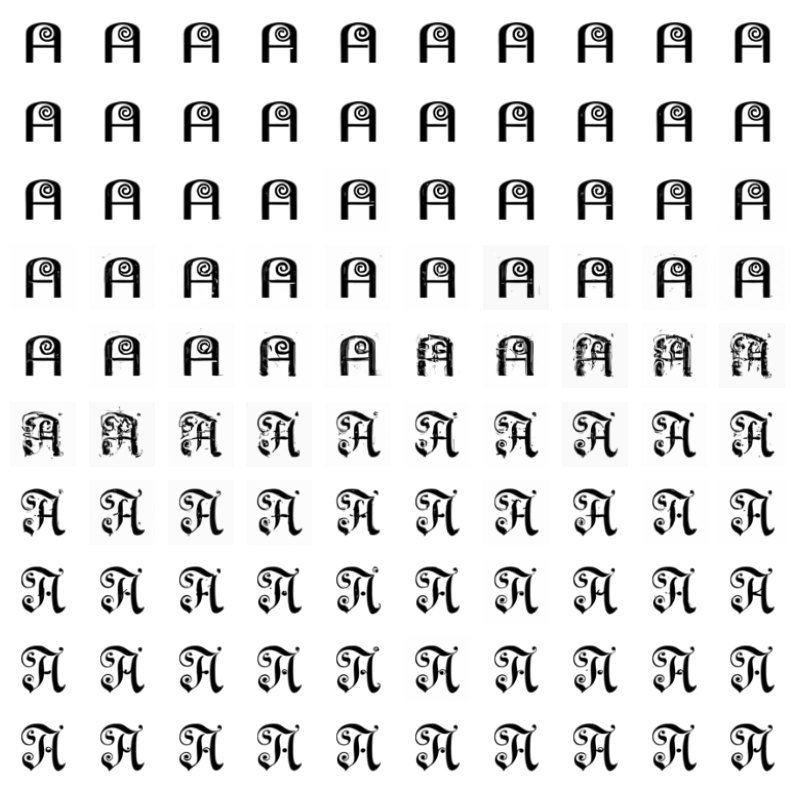

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

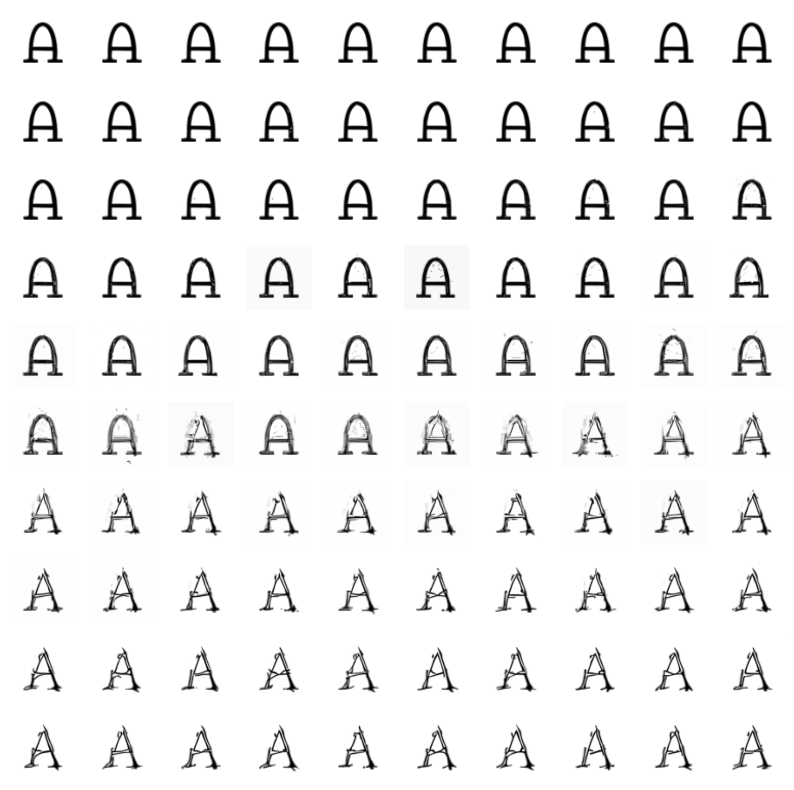

In [13]:
#### class condition 0
style_scale = 3.
class_scale = 0.
char = 'A'
num_split = 100
interpolation_seed = 1
data_type = 'train' # 'train' or 'val' or 'test'
freeze_seed(interpolation_seed)

# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184)]
pair_id = [(222, 275), (28, 40), (91, 184), (284, 249), (284, 494), (710, 494), (693, 769)]

# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]

# google font
# pair_id = [(44,45), (90, 91), (20, 21)]

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)

            style1_noise = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)
            style2_noise = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + \
                    c * pred_noise + \
                    sigma * noise


    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_ddim_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

# スタイルベクトルの内挿

## Bold - Light

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

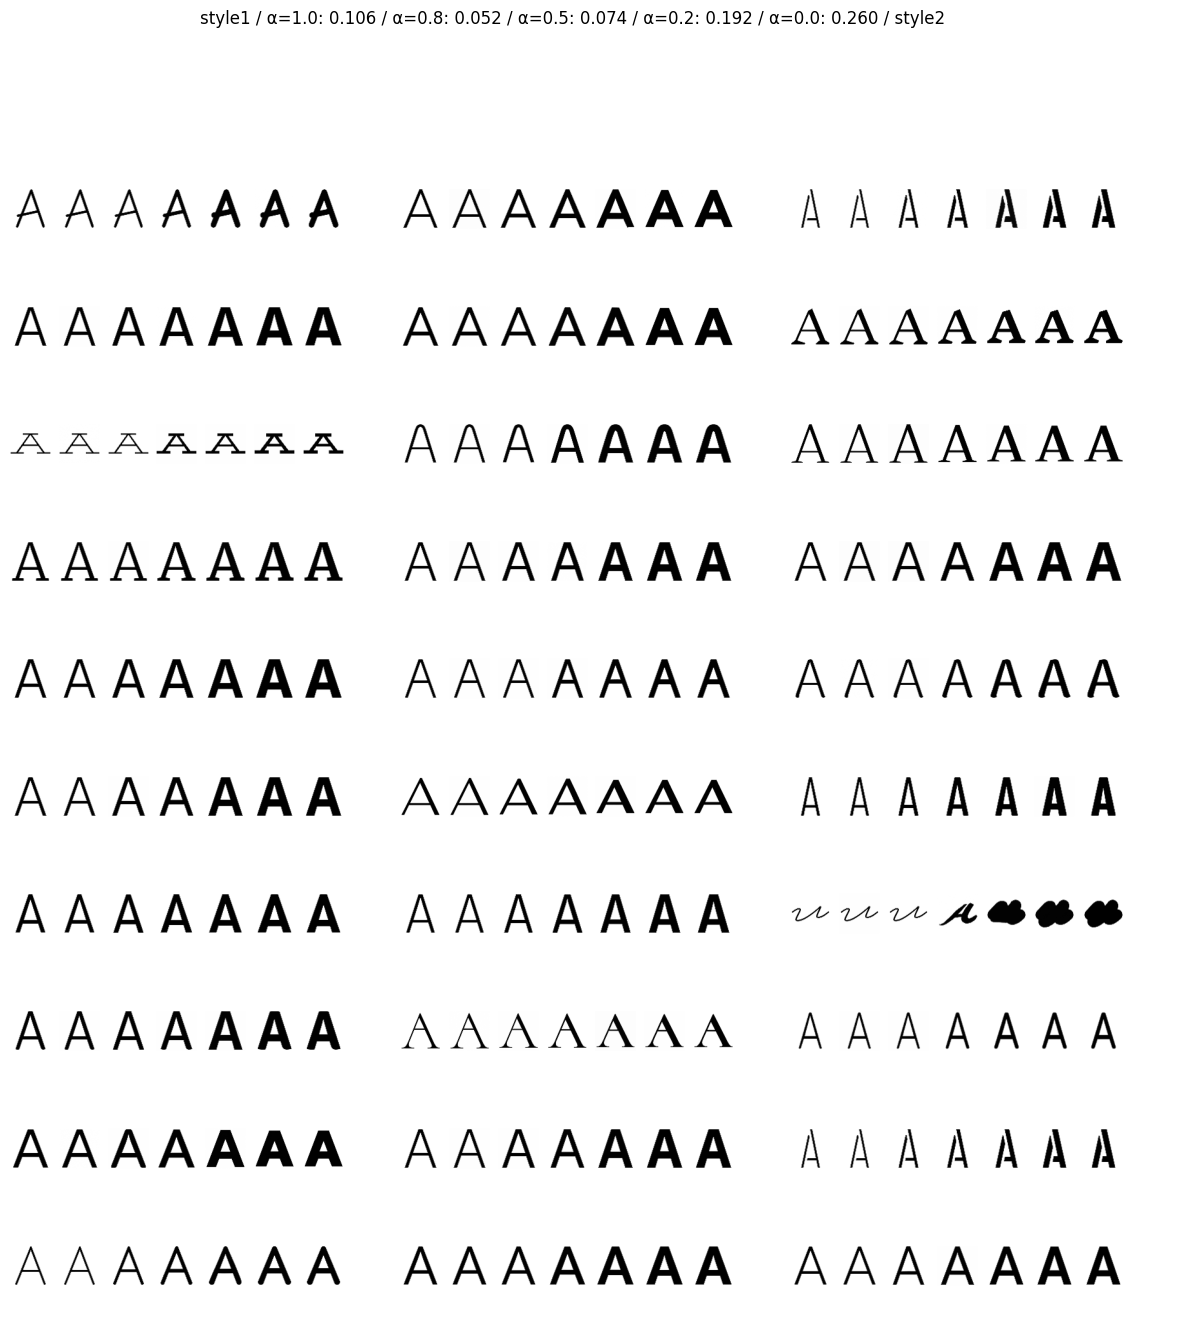

In [ ]:
############ class 非対応 ############

data_dict = {}
weight_cnt = {}
style_num = 1000

# 学習データ（1000データ）からfontのidを取得
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
style_i = 0
for data_type in ['train']:
    data_type_df = df[df['data_type'] == data_type]

    for i in range(len(data_type_df)):
        if style_i >= style_num: break
        p = os.path.join('../font2img/image', data_type_df.loc[i, 'font'])
        if os.path.isdir(p) == False: continue

        if '-' in data_type_df.loc[i, 'font']:
            fontfamily = data_type_df.loc[i, 'font'].split('-')[0]
            weight = data_type_df.loc[i, 'font'].split('-')[1]
            if fontfamily in data_dict:
                data_dict[fontfamily][weight] = style_i
            else:
                data_dict[fontfamily] = {weight: style_i}

            if weight in weight_cnt:
                weight_cnt[weight] += 1
            else:
                weight_cnt[weight] = 1

        style_i += 1

# print(data_dict)
# print(weight_cnt)

# 3種類のweightを持つfontのみを抽出
pair_data_list = []
for font, weights in data_dict.items():
    if 'Bold' in weights and 'Regular' in weights and 'Light' in weights:
        pair_data_list.append({'Bold': weights['Bold'], 'Regular': weights['Regular'], 'Light': weights['Light']})

# print(pair_data_list)

# 内挿
style_scale = 0.
b = min(30, len(pair_data_list))

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[pair_data_list[i]['Light']][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[pair_data_list[i]['Bold']][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([pair_data_list[i]['Light'] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([pair_data_list[i]['Bold'] for i in range(b)], device=device, dtype=torch.long)
gt = torch.cat([d[pair_data_list[i]['Regular']][0] for i in range(b)]).unsqueeze(1).to(device)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_emb_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

loss_alpha = {}
for a in img_alpha.keys():
    loss_alpha[a] = nn.L1Loss()(torch.clamp(img_alpha[a], min=-1., max=1.), gt)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[pair_data_list[i]['Light']][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[pair_data_list[i]['Bold']][0][0], cmap='gray')

title = 'style1 / '
for a, loss in loss_alpha.items():
    title += f'α={a}: {loss.item():.3f} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{style_scale}.png")

## random

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

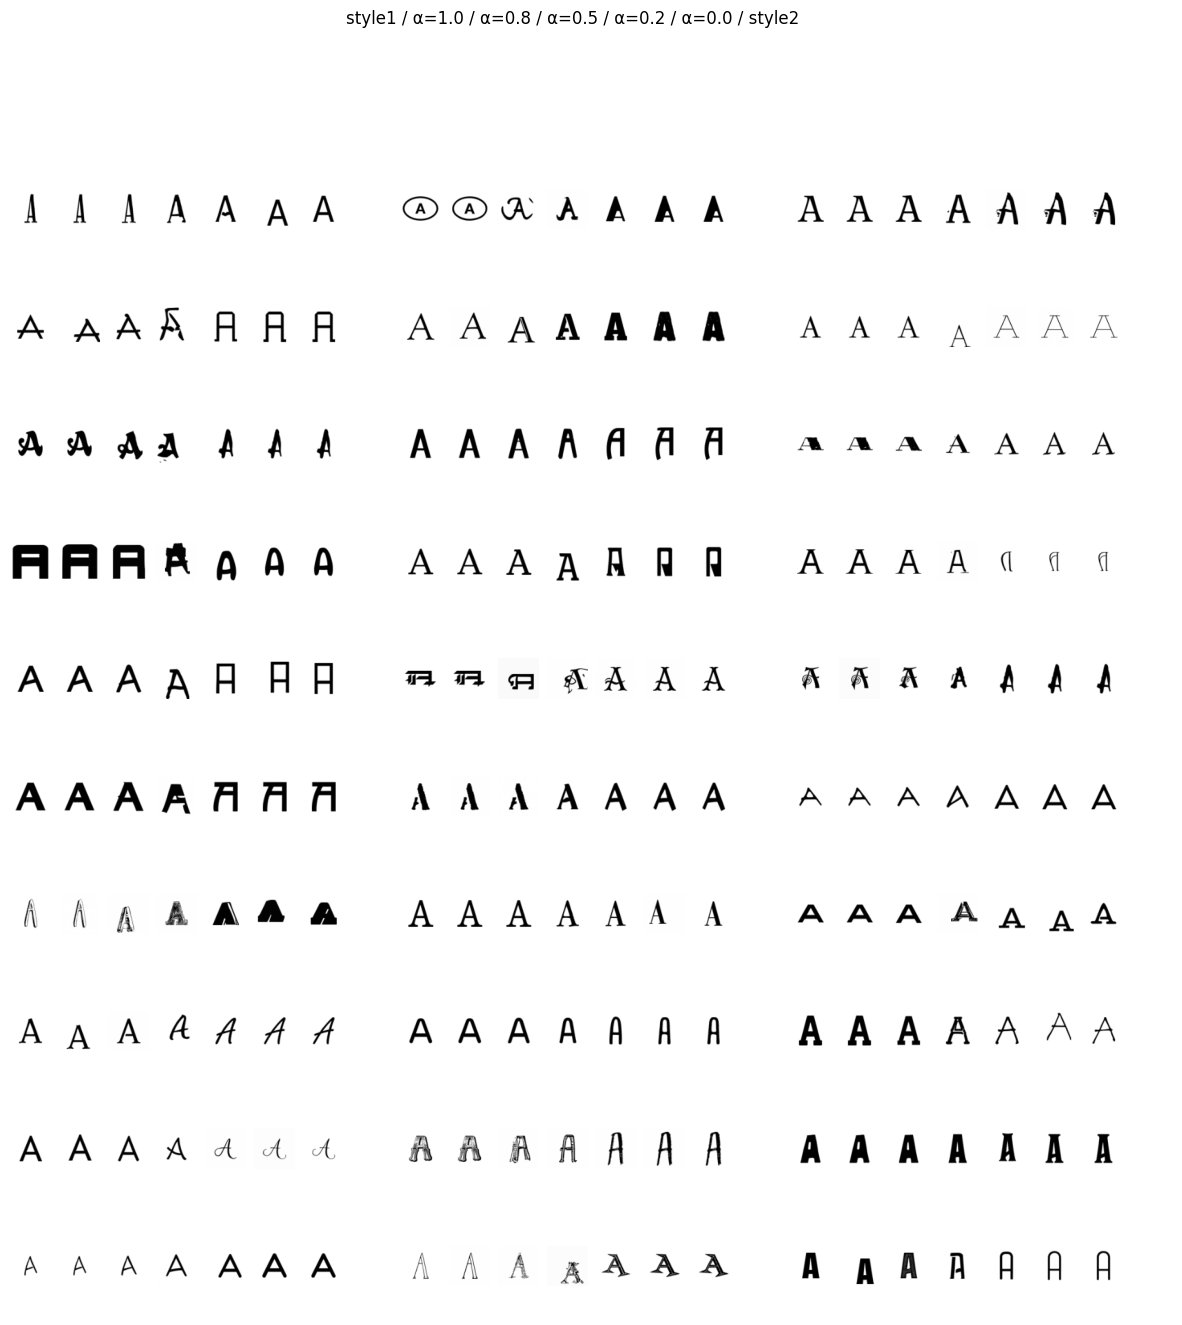

In [ ]:
############ class 非対応 ############

# いろんなフォントの内挿
style_scale = 1.
b = 30
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.randint(0, num_style, (b,))
style2_id = torch.randint(0, num_style, (b,))

img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_emb_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2_id[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{style_scale}_id_{interpolation_seed}.png")

## Pick

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

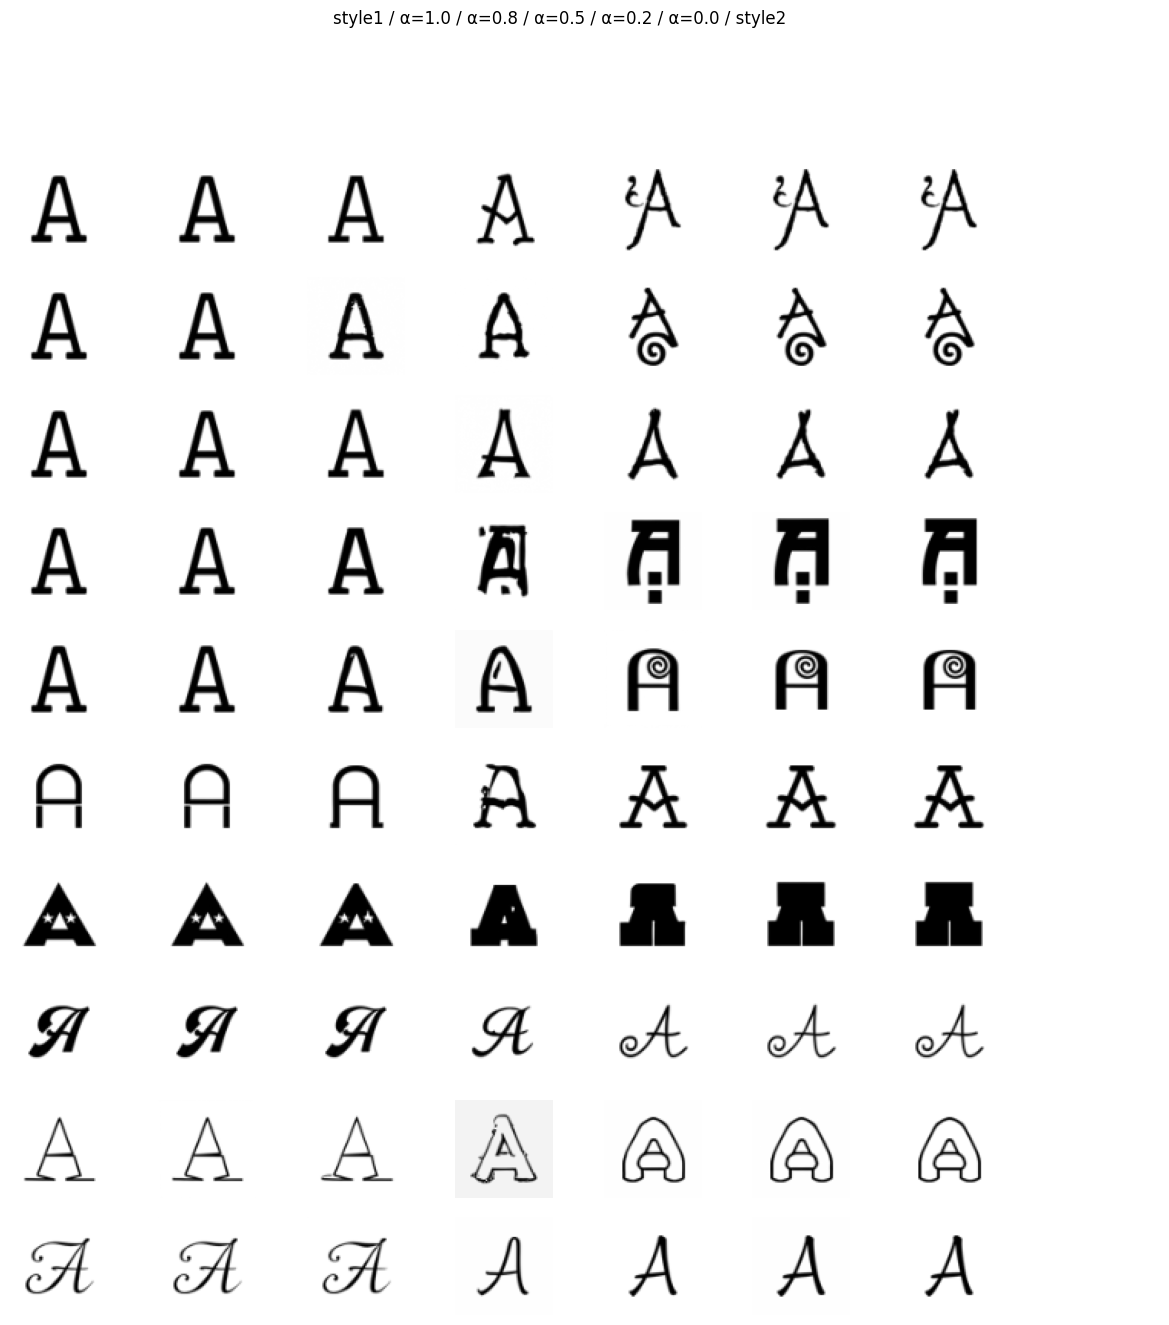

In [ ]:
############ class 非対応 ############

# 自分で用意したフォントの内挿
style_scale = 3.
pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
            (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.tensor([pair_id[i][0] for i in range(len(pair_id))], device=device, dtype=torch.long)
style2_id = torch.tensor([pair_id[i][1] for i in range(len(pair_id))], device=device, dtype=torch.long)
b = min(30, style1_id.size(0))

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_emb_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*((b+9)//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2_id[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{style_scale}.png")

## いろんなα

In [ ]:
style_scale = 3.
class_scale = 1.
num_split = 100
char = 'A'
interpolation_seed = 1

freeze_seed(interpolation_seed)

# myfonts
# pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
#             (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
# pair_id = [(90, 96), (63, 77), (185, 190), (471, 491), (710, 722)]
# pair_id = [(222, 275), (28, 40), (185, 198), (274, 284)]
# pair_id = [(275, 185), (284, 249), ]
pair_id = [(222, 275), (28, 40), (185, 198), (274, 284)]


# google fonts
# pair_id = [(0, 7), (115, 117), (12, 56), (117, 148)]

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2
    style_vector1 = d[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style_vector2 = d[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style = torch.cat([(i/(num_split-1))*style_vector1 + (1-i/(num_split-1))*style_vector2 for i in range(num_split)])
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    b = style.shape[0]
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for i in range(b)])

    with torch.no_grad():
        for t_index in tqdm(reversed(range(0, timesteps))):
            t = torch.full((b,), t_index, device=device, dtype=torch.long)
            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            style_noise = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
            class_noise = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
            nocond_noise = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=1.)
            pred_noise = nocond_noise + style_scale*(style_noise - nocond_noise) + class_scale*(class_noise - nocond_noise)
            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_index == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                _noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * _noise

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{class_scale}_{style_scale}_style_{style1_id}_{style2_id}.png")
    plt.show()

### ddim

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

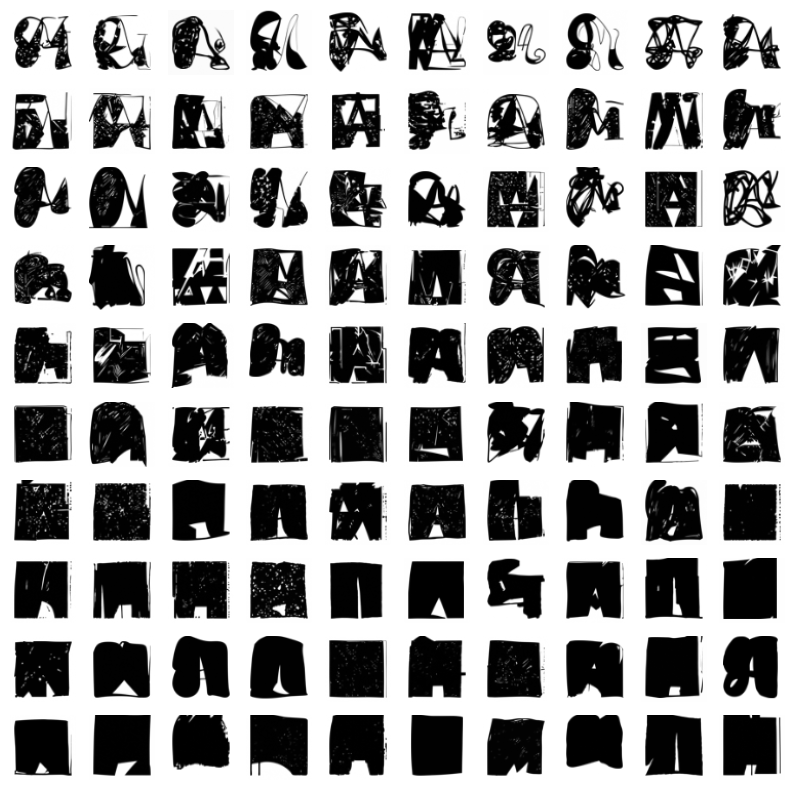

In [9]:
style_scale = 3.
class_scale = 3.
num_split = 100
char = 'A'
interpolation_seed = 1
data_type = 'train' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Condition'

freeze_seed(interpolation_seed)

# myfonts
# train
# pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
#             (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
# pair_id = [(90, 96), (63, 77), (185, 190), (471, 491), (710, 722)]
# pair_id = [(222, 275), (28, 40), (185, 198), (274, 284)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
            (284, 249), (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
            (91, 406), (80, 471), ]
pair_id = [(222, 275)]

# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]

# google fonts
# pair_id = [(0, 7), (115, 117), (12, 56), (117, 148)]


if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2
    style_vector1 = data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style_vector2 = data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style = torch.cat([(i/(num_split-1))*style_vector1 + (1-i/(num_split-1))*style_vector2 for i in range(num_split)])
    b = style.shape[0]
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for i in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)
            pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=0.)
            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + \
                    c * pred_noise + \
                    sigma * noise

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_ddim_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i/(num_split-1)) for i in range(num_split)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)


tensor([0.1269, 0.1364, 0.1365, 0.1373, 0.1380, 0.1385, 0.1397, 0.1401, 0.1446,
        0.1448])


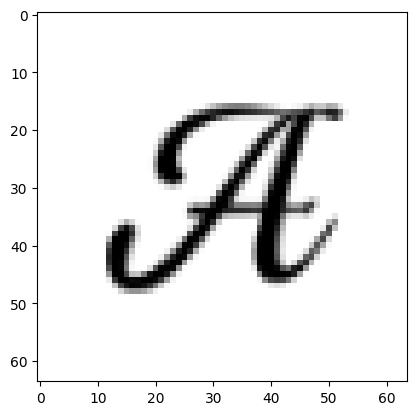

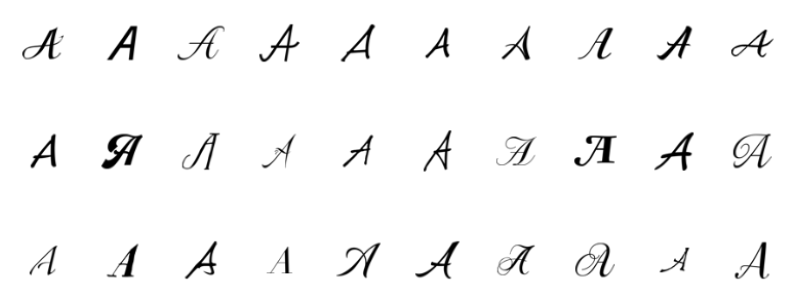

In [ ]:
# 生成画像と似ているtrainデータを探す
target_i = 50
# target = torch.where(x[target_i][0] > 0., torch.tensor(1.), torch.tensor(-1.))
target = torch.clamp(x[target_i][0], min=-1., max=1.)

loss_list = []
for batch, _ in d:
    batch = batch.to(device)
    loss = nn.L1Loss()(target, batch)
    loss_list.append(loss)
loss_list = torch.tensor(loss_list)
similar_index = torch.argsort(loss_list)
print(loss_list[similar_index[:10]])

plt.imshow(target.cpu().detach(), cmap='gray')

fig, ax = plt.subplots(3, 10, figsize=(10, 4))
for i in range(30):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[similar_index[i]][0][0], cmap='gray')

# ノイズの局所的重み付け

## 上下

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

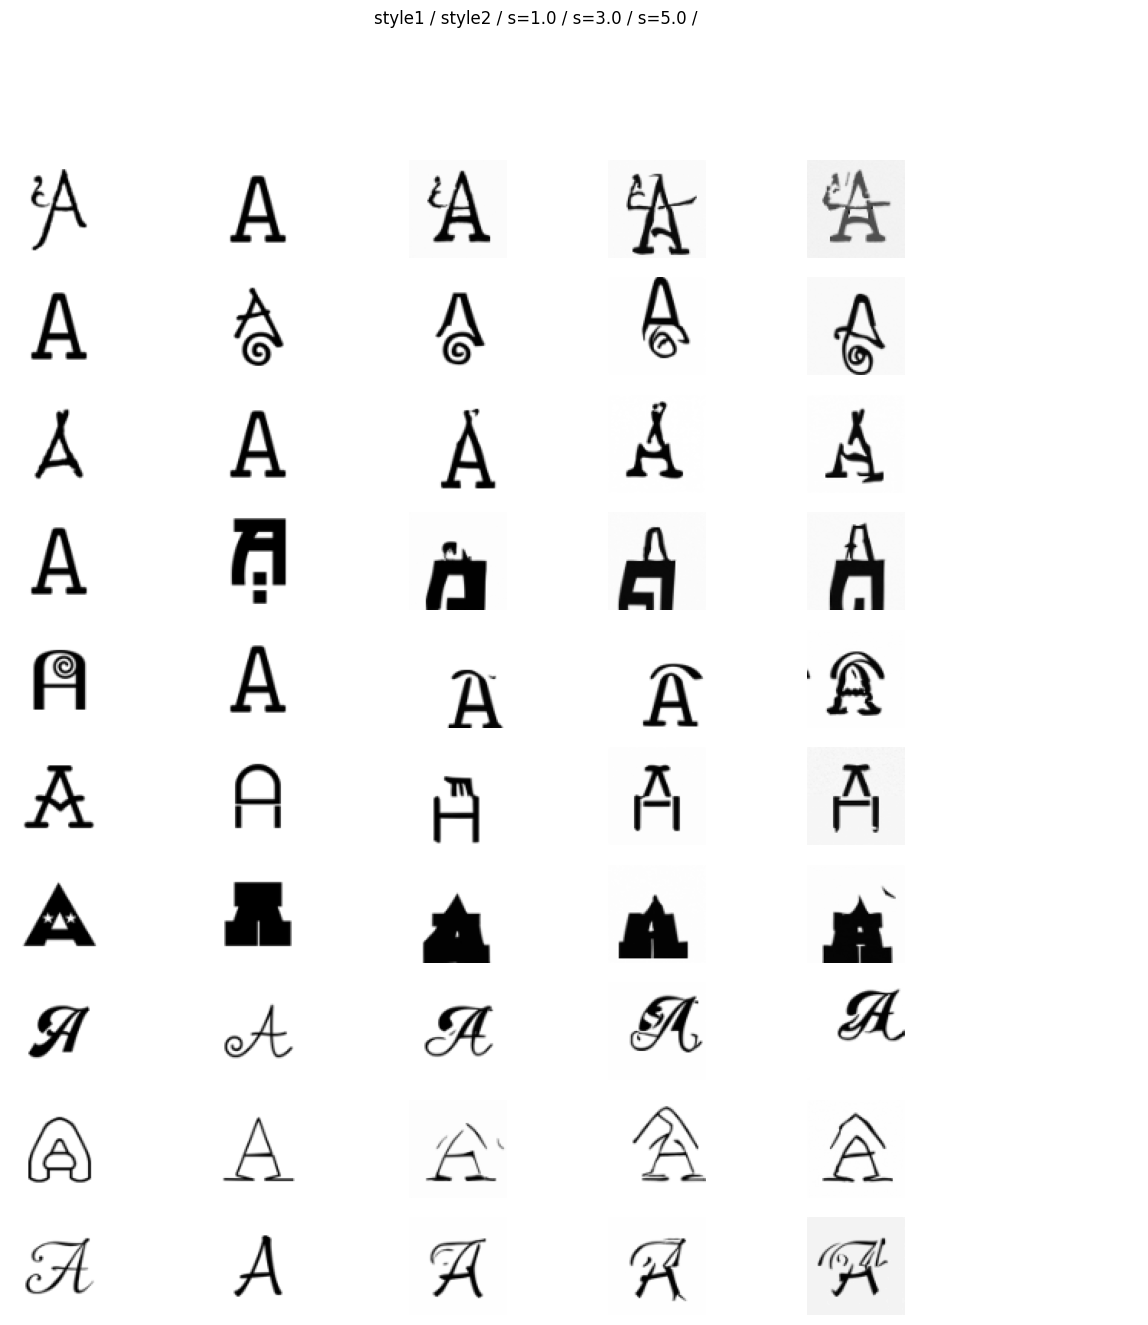

In [ ]:
@torch.no_grad()
def p_sample_noise_local_weighting(model, x, style1, style2, t, scale, s1_mask, s2_mask):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predict noise
    style1_noise = model.forward_with_cond_scale(x, t, style1, style_scale=scale, rescaled_phi=0.)
    style2_noise = model.forward_with_cond_scale(x, t, style2, style_scale=scale, rescaled_phi=0.)

    # local weighting
    pred_noise = s1_mask * style1_noise + s2_mask * style2_noise

    # sampling
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# s1が上半分，s2が下半分
pair_id = [(184, 91), (91, 249), (406, 91), (91, 439), (494, 91),
            (471, 80), (4, 261), (222, 275), (265, 256), (460, 491)]
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.tensor([pair_id[i][0] for i in range(len(pair_id))], device=device, dtype=torch.long)
style2_id = torch.tensor([pair_id[i][1] for i in range(len(pair_id))], device=device, dtype=torch.long)
b = min(30, style1_id.size(0))

one_mask = torch.ones(b, 1, image_size//2, image_size)
zero_mask = torch.zeros(b, 1, image_size//2, image_size)
s1_mask = torch.cat([one_mask, zero_mask], dim=2).to(device)
s2_mask = 1. - s1_mask

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_scale = {a: img for a in [1., 3., 5.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_scale.keys():
        img_scale[a] = p_sample_noise_local_weighting(model, img_scale[a], style1, style2, t, a, s1_mask, s2_mask)

fig, ax = plt.subplots(10, 6*((b+9)//10), figsize=(15, 15))
for i in range(b):
    for j in range(6):
        ax[i%10, 6*(i//10)+j].axis('off')

    ax[i%10, 6*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    ax[i%10, 6*(i//10)+1].imshow(d[style2_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_scale.keys()):
        ax[i%10, 6*(i//10)+j+2].imshow(img_scale[a][i][0].cpu().detach().clone(), cmap='gray')

title = 'style1 / style2 / '
for a in img_scale.keys():
    title += f's={a} / '
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_local_weighting.png")

## local style awareness

# ノイズの演算

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

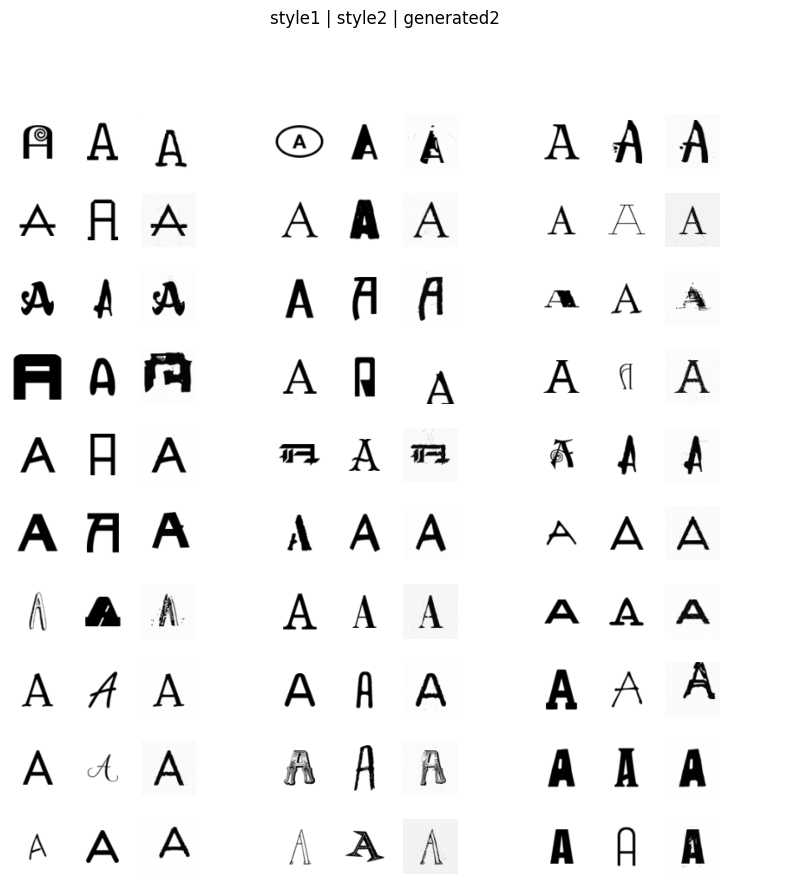

In [ ]:
# 推定ノイズの足し算
style1_scale = 2.
style2_scale = 2.
b = 30
topk = int(64*64*0.1)

freeze_seed(1)

style1_id = torch.randint(0, num_style, (b,))
style2_id = torch.randint(0, num_style, (b,))
style1_id[0] = torch.tensor(494)
style2_id[0] = torch.tensor(91)

img = torch.randn((b, channels, image_size, image_size), device=device)
# img2 = img.clone()
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)


for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    betas_t = extract(betas, t, img.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, img.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, img.shape)

    with torch.no_grad():
        style1_noise = model(img, t, style1, style_drop_prob=0.)
        style2_noise = model(img, t, style2, style_drop_prob=0.)
        nocond_noise = model(img, t, style1, style_drop_prob=1.)

        # style1_diff_noise = style1_noise - nocond_noise
        # topk_value = torch.topk(torch.abs(style1_diff_noise.view(b, -1)), topk)[0]
        # custum_style1_scale = torch.cat([style1_scale*(topk_value[j][topk-1] <= torch.abs(style1_diff_noise[j])).unsqueeze(1) for j in range(b)])

        style2_diff_noise = style2_noise - nocond_noise
        topk_value = torch.topk(torch.abs(style2_diff_noise.view(b, -1)), topk)[0]
        custum_style2_scale = torch.cat([style2_scale*(topk_value[j][topk-1] <= torch.abs(style2_diff_noise[j])).unsqueeze(1) for j in range(b)])

        # pred_noise = nocond_noise + custum_style1_scale*style1_diff_noise + custum_style2_scale*style2_diff_noise
        pred_noise = nocond_noise + style1_scale*(style1_noise - nocond_noise) + custum_style2_scale*style2_diff_noise
        # pred_noise = nocond_noise + style1_scale*(style1_noise - nocond_noise) + style2_scale*(style2_noise - nocond_noise)
        model_mean = sqrt_recip_alphas_t * (img - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if i == 0:
        img = model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, img.shape)
        noise = torch.randn_like(img)
        img = model_mean + torch.sqrt(posterior_variance_t) * noise

fig, ax = plt.subplots(10, 12, figsize=(10, 10))
for i in range(b):
    for j in range(4):
        ax[i%10, 4*(i//10)+j].axis('off')
    ax[i%10, 4*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    ax[i%10, 4*(i//10)+1].imshow(d[style2_id[i]][0][0], cmap='gray')
    ax[i%10, 4*(i//10)+2].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
fig.suptitle(f'style1 | style2 | generated2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_operation_scale{style1_scale}_{style2_scale}_topk_{topk}_id{style1_id.sum()}.png")

In [ ]:
# 線を太くする
light_id = 60
bold_id = 61

style_scale = 3.

b = 10
img = torch.randn((b, channels, image_size, image_size), device=device)
img2 = torch.randn((b, channels, image_size, image_size), device=device)
style = torch.randint(0, 1000, (b,), device=device, dtype=torch.long)
light_style = torch.tensor([light_id for i in range(b)], device=device, dtype=torch.long)
bold_style = torch.tensor([bold_id for i in range(b)], device=device, dtype=torch.long)


for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    betas_t = extract(betas, t, img.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, img.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, img.shape)

    with torch.no_grad():
        # 単純にsampling
        pred_noise = model.forward_with_cond_scale(img, t, style, style_scale=style_scale, rescaled_phi=0.)
        model_mean = sqrt_recip_alphas_t * (img - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        # bold - light のノイズを加える
        bold_noise = model.forward_with_cond_scale(img2, t, bold_style, style_scale=style_scale, rescaled_phi=0.)
        light_noise = model.forward_with_cond_scale(img2, t, light_style, style_scale=style_scale, rescaled_phi=0.)
        pred_noise2 = model.forward_with_cond_scale(img2, t, style, style_scale=style_scale, rescaled_phi=0.)
        pred_noise2 = pred_noise2 + (bold_noise - light_noise)
        model_mean2 = sqrt_recip_alphas_t * (img2 - betas_t * pred_noise2 / sqrt_one_minus_alphas_cumprod_t)

    if i == 0:
        img = model_mean
        img2 = model_mean2
    else:
        posterior_variance_t = extract(posterior_variance, t, img.shape)
        noise = torch.randn_like(img)
        img = model_mean + torch.sqrt(posterior_variance_t) * noise
        img2 = model_mean2 + torch.sqrt(posterior_variance_t) * noise

fig, ax = plt.subplots(b, 3, figsize=(3, int(b*0.8)))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(img2[i][0].cpu().detach().clone(), cmap='gray')
fig.suptitle(f'GT | generated1 | generated2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_operation2_scale{style_scale}_id{style.sum()}.png")

# スタイルベクトルの演算

In [ ]:
style_scale = 3.
pair_id = [(184, 91, 90)]
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.tensor([pair_id[i][0] for i in range(len(pair_id))], device=device, dtype=torch.long)
style2_id = torch.tensor([pair_id[i][1] for i in range(len(pair_id))], device=device, dtype=torch.long)
b = min(30, style1_id.size(0))

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_emb_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*((b+9)//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2_id[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{style_scale}.png")

# SDEdit

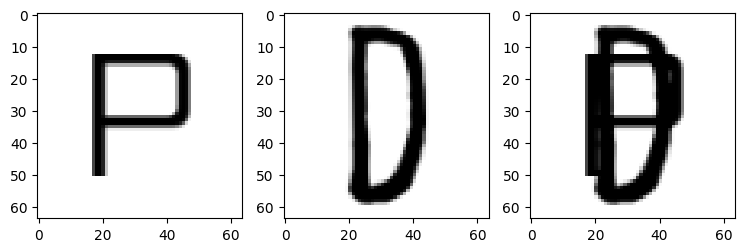

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000, -0.4572, -0.9983, -1.0000, -0.9579, -0.8672, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.2618,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.7901, -0.8731, -1.0000,
        -1.0000, -1.0000, -0.9951, -0.0793,  0.9603,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])


In [5]:
# 画像の足し方を変える
# -1 ~ 1の範囲で足し算すると、黒い部分が薄くなる

img1 = d[275][0]
img2 = d[185][0]
img3 = 2*(1 - torch.clamp(2 - (img1+1)*0.5 - (img2+1)*0.5, min=0., max=1.)) - 1

fig, ax = plt.subplots(1, 3, figsize=(9, 6))
ax[0].imshow(img1[0], cmap='gray')
ax[1].imshow(img2[0], cmap='gray')
ax[2].imshow(img3[0], cmap='gray')
plt.show()

print(img3[0][40])

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

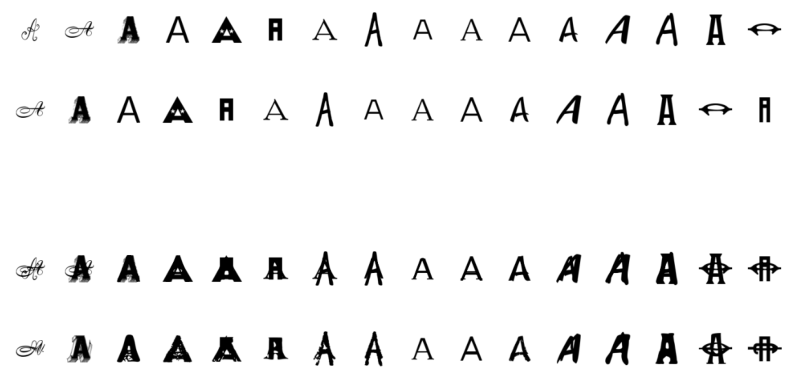

In [61]:
imgs1 = []
imgs2 = []
imgs3 = []
imgs = []
style1 = []
style2 = []
char = 'A'
style1_scale = 0.
style2_scale = 3.
class_scale = 0.
sampling_t = int(0.5 * timesteps)

# myfonts
# pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
#             (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
# pair_id = [(90, 96), (63, 77), (185, 190), (471, 491), (710, 722)]
pair_id = [(222, 275), (28, 40), (275, 185), (284, 249)]

# google fonts
# pair_id = [(201, 117), (148, 117), (288, 363), (115, 148), (288, 117), ]

freeze_seed(1)

for s1, s2 in pair_id:
    s1 = num_class*s1 + (ord(char) - ord('A'))
    s2 = num_class*s2 + (ord(char) - ord('A'))
    imgs1.append(d[s1][0])
    imgs2.append(d[s2][0])
    # imgs3.append(d[s3][0])
    # 演算
    # imgs.append(torch.clamp((d[s1][0] - d[s2][0] + d[s3][0]), min=-1, max=1))
    # ORで黒く
    img1 = d[s1][0]
    img2 = d[s2][0]
    img3 = 2*(1 - torch.clamp(2 - (img1+1)*0.5 - (img2+1)*0.5, min=0., max=1.)) - 1
    # ANDのとこを黒く
    # img1 = d[s1][0]
    # img2 = d[s2][0]
    # img3 = ((img1+1)*0.5 + (img2+1)*0.5) - 1
    # ２値化
    # img1 = torch.where(d[s1][0]>0, torch.tensor(1.), torch.tensor(0))
    # img2 = torch.where(d[s2][0]>0, torch.tensor(1.), torch.tensor(0))
    # img3 = 2 * (1 - torch.clamp(2 - (img1 + img2), min=0., max=1.)) - 1
    imgs.append(img3)

    # style.append(F.normalize(d[s1][1] - d[s2][1] + d[s3][1], dim=0))
    style1.append(d[s1][1])
    style2.append(d[s2][1])
    # style.append(F.normalize(d[s1][1] + d[s2][1], dim=0))
    # style.append((d[s1][1] + d[s2][1])/2.)

imgs = torch.stack(imgs).to(device)
style1 = torch.stack(style1).to(device)
style2 = torch.stack(style2).to(device)

b = imgs.shape[0]
t = torch.full((b,), sampling_t-1, device=device, dtype=torch.long)
classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)

noisy_imgs = q_sample(imgs, t)

out = noisy_imgs
with torch.no_grad():
    for i in tqdm(reversed(range(0, sampling_t)), desc='sampling loop time step', total=sampling_t):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        betas_t = extract(betas, t, out.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, out.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, out.shape)

        nocond_noise = model(out, t, classes, style1, class_drop_prob=1., style_drop_prob=1.)
        pred_noise = nocond_noise.clone()

        if class_scale > 0.:
            pred_noise += class_scale  * (model(out, t, classes, style1, class_drop_prob=0., style_drop_prob=1.) - nocond_noise)
        if style1_scale > 0.:
            pred_noise += style1_scale * (model(out, t, classes, style1, class_drop_prob=1., style_drop_prob=0.) - nocond_noise)
        if style2_scale > 0.:
            pred_noise += style2_scale * (model(out, t, classes, style2, class_drop_prob=1., style_drop_prob=0.) - nocond_noise)

        model_mean = sqrt_recip_alphas_t * (out - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        if i == 0:
            out = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, out.shape)
            _noise = torch.randn_like(out)
            out = model_mean + torch.sqrt(posterior_variance_t) * _noise

fig, ax = plt.subplots(5, b, figsize=(10, 5))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')
    ax[0, i].imshow(imgs1[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(imgs2[i][0].cpu().detach(), cmap='gray')
    # ax[2, i].imshow(imgs3[i][0].cpu().detach(), cmap='gray')
    ax[3, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[4, i].imshow(out[i][0].cpu().detach(), cmap='gray')

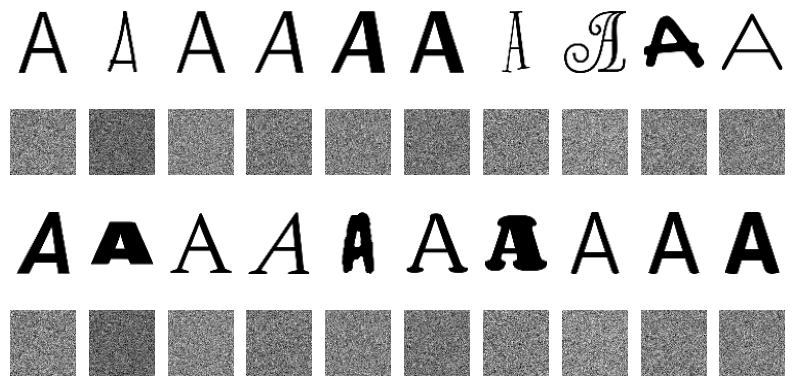

In [ ]:
imgs = []
gt = []
style = []
for i in range(10):
    imgs.append(d[i][0])
    style.append(d[i+100][1])
    gt.append(d[i+100][0])
imgs = torch.stack(imgs).to(device)
style = torch.stack(style).to(device)
gt = torch.stack(gt).to(device)

sampling_t = int(0.999 * timesteps)
t = torch.full((10,), sampling_t, device=device, dtype=torch.long)
noisy_imgs = q_sample(imgs, t)

out = noisy_imgs
for i in tqdm(reversed(range(0, sampling_t+1)), desc='sampling loop time step', total=timesteps):
    t = torch.full((10,), i, device=device, dtype=torch.long)
    out = p_sample(model, out, style, t, i, style_scale=3., rescaled_phi=0)

fig, ax = plt.subplots(4, 10, figsize=(10, 5))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[0, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i][0].cpu().detach(), cmap='gray')
    ax[2, i].imshow(gt[i][0].cpu().detach(), cmap='gray')
    ax[3, i].imshow(out[i][0].cpu().detach(), cmap='gray')

# 推定ノイズの値の分布

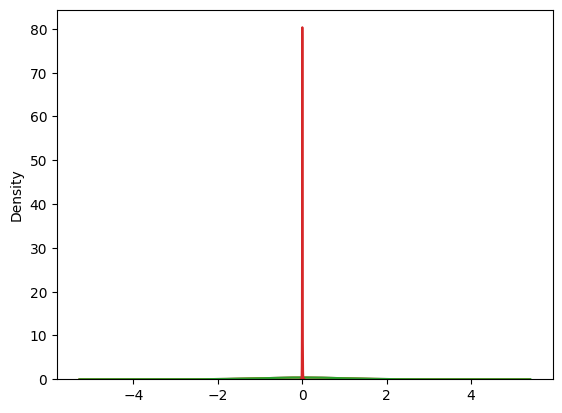

In [ ]:
b = 128
style_scale = 3.

cond_noise_value = []
nocond_noise_value = []
scaled_noise_value = []
diff_noise_value = []

with torch.no_grad():
    for _ in range(10):
        x = torch.randn_like(torch.zeros((b, 1, image_size, image_size)), device=device)
        for t_index in reversed(range(0, timesteps)):
            t = torch.full((b,), t_index, device=device, dtype=torch.long)
            style = torch.randint(0, num_style, (b,), device=device).long()
            if use_style_encoder == True:
                style = torch.cat([d[style[i]][1].unsqueeze(0) for i in range(b)]).to(device)

            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            cond_noise = model(x, t, style, style_drop_prob=0.)
            nocond_noise = model(x, t, style, style_drop_prob=1.)
            scaled_noise = style_scale*(cond_noise - nocond_noise) + nocond_noise

            x = sqrt_recip_alphas_t * (x - betas_t * scaled_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_index != 0:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                x = x + torch.sqrt(posterior_variance_t) * noise

            if t_index == timesteps-1:
                cond_noise_value.append(cond_noise.cpu().clone().detach().view(-1))
                nocond_noise_value.append(nocond_noise.cpu().clone().detach().view(-1))
                scaled_noise_value.append(scaled_noise.cpu().clone().detach().view(-1))
                diff_noise_value.append((cond_noise - nocond_noise).cpu().clone().detach().view(-1))

            break

cond_noise_value = torch.cat(cond_noise_value)
nocond_noise_value = torch.cat(nocond_noise_value)
scaled_noise_value = torch.cat(scaled_noise_value)
diff_noise_value = torch.cat(diff_noise_value)

plt.figure()
# sns.kdeplot(cond_noise_value, label='cond_noise')
# sns.kdeplot(nocond_noise_value, label='nocond_noise')
# sns.kdeplot(scaled_noise_value, label='scaled_noise')
sns.kdeplot(diff_noise_value, label='diff_noise')
plt.show()

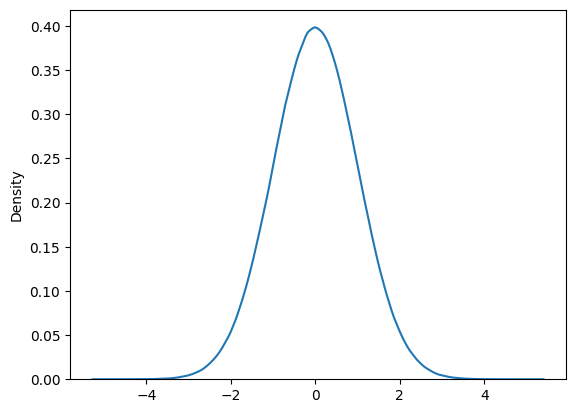

In [ ]:
plt.figure()
# sns.kdeplot(cond_noise_value, label='cond_noise')
# sns.kdeplot(nocond_noise_value, label='nocond_noise')
sns.kdeplot(scaled_noise_value, label='scaled_noise')
# sns.kdeplot(diff_noise_value, label='diff_noise')
plt.show()

# スタイルベクトルと推定ノイズの関係

## PCA

[0.80927855 0.14274637 0.03308946]


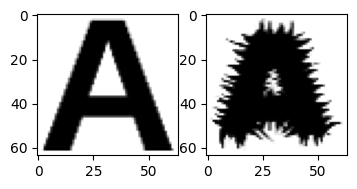

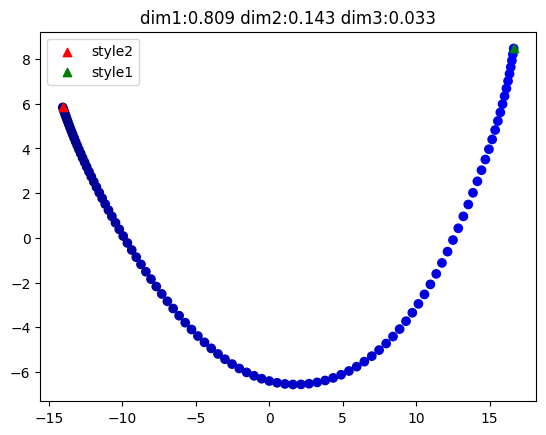

In [ ]:
style1_id = 11
style2_id = 12
num_dim = 64*64
num_split = 100
visualize_t = 500 # from 0 to timesteps-1

style_vector1 = d[style1_id][1].unsqueeze(0).to(device)
style_vector2 = d[style2_id][1].unsqueeze(0).to(device)
style = torch.cat([(i/num_split)*style_vector1 + (1-i/num_split)*style_vector2 for i in range(num_split+1)])
# style = torch.cat([(torch.sin(torch.tensor(i/num_split*torch.math.pi/2)))*style_vector1 + (torch.cos(torch.tensor((i/num_split)*torch.math.pi/2)))*style_vector2 for i in range(num_split+1)])
b = style.shape[0]
x = torch.randn(1, 1, image_size, image_size).to(device)
x = torch.cat([x for i in range(b)])

with torch.no_grad():
    for t_index in reversed(range(0, timesteps)):
        t = torch.full((b,), t_index, device=device, dtype=torch.long)
        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        noise = model(x, t, style, style_drop_prob=0.)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            x = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            _noise = torch.randn_like(x)
            x = model_mean + torch.sqrt(posterior_variance_t) * _noise

        x = torch.cat([x[0] for i in range(b)]).unsqueeze(1)

        if t_index == visualize_t:
            predicted_noise = noise.cpu().detach().numpy().reshape(b, -1)
            break

# show style1 and style2
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(d[style1_id][0][0], cmap='gray')
ax[1].imshow(d[style2_id][0][0], cmap='gray')

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(predicted_noise)
print(pca.explained_variance_ratio_)

# 2次元plot
color = [(0, 0, 0.5 + 0.5*i/num_split) for i in range(num_split+1)]
fig, ax = plt.subplots(1, 1)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)
ax.scatter(X_reduced[0, 0], X_reduced[0, 1], c='red', marker='^', label='style2')
ax.scatter(X_reduced[-1, 0], X_reduced[-1, 1], c='green', marker='^', label='style1')
ax.set_title(f'dim1:{pca.explained_variance_ratio_[0]:.3f} dim2:{pca.explained_variance_ratio_[1]:.3f} dim3:{pca.explained_variance_ratio_[2]:.3f}')
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_pca_2d_t_{visualize_t}_style_{style1_id}_{style2_id}.png")
plt.show()

# # 3次元plot
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='blue', marker='o', label='Data Points')
# ax.scatter(X_reduced[0, 0], X_reduced[0, 1], X_reduced[0, 2], c='red', marker='^', label='style2')
# ax.scatter(X_reduced[-1, 0], X_reduced[-1, 1], X_reduced[-1, 2], c='green', marker='^', label='style1')
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')
# ax.set_title(f'dim1:{pca.explained_variance_ratio_[0]:.3f} dim2:{pca.explained_variance_ratio_[1]:.3f} dim3:{pca.explained_variance_ratio_[2]:.3f}')
# # # 超平面
# # normal_vector = np.cross(X_reduced[0], X_reduced[-1])
# # xx, yy = np.meshgrid(range(-3, 4), range(-3, 4))
# # xx = xx / 10.
# # yy = yy / 10.
# # zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
# # ax.plot_surface(xx, yy, zz, alpha=0.5, color='red', label='Hyperplane')
# plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_pca_3d_t_{visualize_t}_style{style1_id}_{style2_id}.png")
# plt.show()

## ノルムと角度

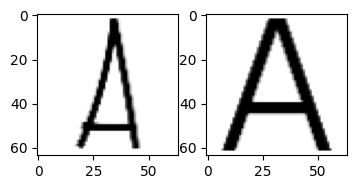

<Figure size 1000x600 with 0 Axes>

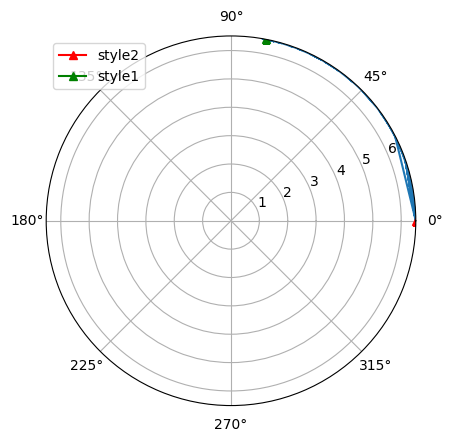

In [ ]:
style1_id = 1
style2_id = 60
num_dim = 64*64
num_split = 100
visualize_t = 999 # from 0 to timesteps-1

style_vector1 = d[style1_id][1].unsqueeze(0).to(device)
style_vector2 = d[style2_id][1].unsqueeze(0).to(device)
style = torch.cat([(i/num_split)*style_vector1 + (1-i/num_split)*style_vector2 for i in range(num_split+1)])
b = style.shape[0]
x = torch.randn(1, 1, image_size, image_size).to(device)
x = torch.cat([x for i in range(b)])

with torch.no_grad():
    for t_index in reversed(range(0, timesteps)):
        t = torch.full((b,), t_index, device=device, dtype=torch.long)
        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        noise = model(x, t, style, style_drop_prob=0.)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            x = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            _noise = torch.randn_like(x)
            x = model_mean + torch.sqrt(posterior_variance_t) * _noise

        x = torch.cat([x[0] for i in range(b)]).unsqueeze(1)

        if t_index == visualize_t:
            predicted_noise = noise.cpu().detach().numpy().reshape(b, -1)
            break

# 各データ点とベクトルaのなす角度を計算
cos_sim = np.dot(predicted_noise, predicted_noise[0])\
            / (np.linalg.norm(predicted_noise, axis=1) * np.linalg.norm(predicted_noise[0]))
angles = np.arccos(np.clip(cos_sim, -1.0, 1.0))

# 各データ点のノルムを計算
norms = np.linalg.norm(predicted_noise, axis=1)

# show style1 and style2
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(d[style1_id][0][0], cmap='gray')
ax[1].imshow(d[style2_id][0][0], cmap='gray')
plt.show()

# 散布図の作成
color = [(0, 0, 0.5 + 0.5*i/num_split) for i in range(num_split+1)]
fig = plt.figure(figsize=(10, 6))
plt.figure()
plt.scatter(angles, norms, color=color)
plt.scatter(angles[0], norms[0], c='red', marker='^', label='style2')
plt.scatter(angles[-1], norms[-1], c='green', marker='^', label='style1')
# rate = 1.4/angles.max()
# plt.polar(angles*rate, norms)
# plt.polar(angles[0]*rate, norms[0], c='red', marker='^', label='style2')
# plt.polar(angles[-1]*rate, norms[-1], c='green', marker='^', label='style1')
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_polar_t_{visualize_t}_style_{style1_id}_{style2_id}.png")
plt.show()


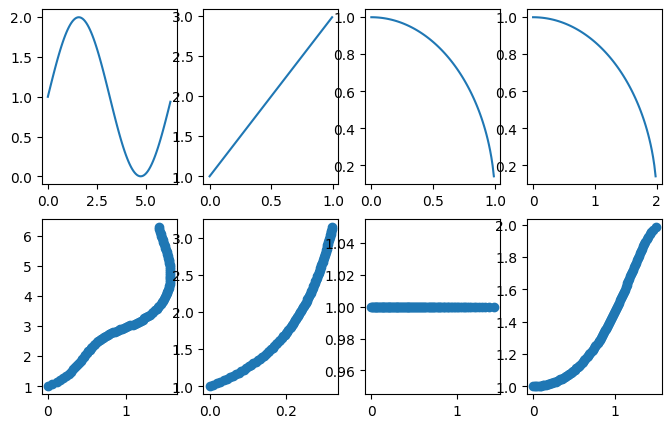

In [ ]:
num_split = 100
fig, ax = plt.subplots(2, 4, figsize=(8, 5))

for i in range(4):
    if i == 0:
        # sin
        x = np.arange(0, 2*np.pi, 2*np.pi/num_split)
        y = np.sin(x) + 1

    elif i == 1:
        # 直線
        x = np.arange(0, 1, 1/num_split)
        y = 2*x + 1

    elif i == 2:
        # 円
        x = np.arange(0, 1, 1/num_split)
        y = np.sqrt(1 - x**2)
    elif i == 3:
        # 楕円
        x = np.arange(0, 2, 2/num_split)
        y = np.sqrt(1 - (x**2)/4)

    xy = np.stack([x, y]).T
    cos_sim = np.dot(xy, xy[0]) / (np.linalg.norm(xy, axis=1) * np.linalg.norm(xy[0]))
    angles = np.arccos(np.clip(cos_sim, -1.0, 1.0))
    norms = np.linalg.norm(xy, axis=1)
    ax[0, i].plot(x, y)
    # ax[1, i].polar(angles, norms)
    ax[1, i].scatter(angles, norms)

plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3次元データを生成
num_points = 100
dim = 3
a = torch.randn(dim)
b = torch.randn(dim)

data = []
for i in range(num_points + 1):
    alpha = i / num_points
    data.append((alpha * a + (1 - alpha) * b).numpy())

data = np.array(data)

# プロット
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o', label='Data Points')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Visualization of Hyperplane in 3D Space')

# 超平面を可視化
normal_vector = np.cross(a.numpy(), b.numpy())
xx, yy = np.meshgrid(range(-3, 4), range(-3, 4))
zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
ax.plot_surface(xx, yy, zz, alpha=0.5, color='red', label='Hyperplane')

plt.show()


# 文字認識モデルの性能評価

In [7]:
# build model
classifier = models.resnet50()
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
classifier.fc = nn.Linear(classifier.fc.in_features, num_class)

# load weight
classifier.to(device)
classifier.load_state_dict(torch.load('weight/char_classifier.pth', map_location=device))
classifier.eval()

for data_type in ['train', 'val', 'test']:
    correct = 0
    for img, _, label in dataloader[data_type]:
        with torch.no_grad():
            img = img.to(device)
            o = classifier((img+1)*0.5).cpu().detach() # 0-1input
            pred = torch.argmax(o, dim=1)
            correct += torch.sum(pred == label.data)

    acc = correct.double() / len(dataloader[data_type].dataset)
    print(f'{data_type} accuracy: {acc:.3f}')

train accuracy: 0.925
val accuracy: 0.802
test accuracy: 0.798


# weightが違うフォントのcsv作り

In [ ]:
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
output_dict = {'style1': [], 'style2': [], 'data_type': [],}

# 189
# serif 42
# sans-serif 122
# display 19
# handwriting 6
# Light 141 - Regular 866 - Bold 268
# LightItalic 54 - Italic 131 - BoldItalic 95
# small = 'Light'
# medium = 'Regular'
# large = 'Bold'

# 134
# serif 28
# sans-serif 99
# display 5
# handwriting 2
# Light 141 - Medium 121 - Bold 268
# LightItalic 54 - MediumItalic 44 - BoldItalic 95
small = 'Light'
medium = 'Medium'
large = 'Bold'

path_list = []
for data_type in ['train', 'valid', 'test']:
    data_type_df = df[df['data_type'] == data_type].reset_index(drop=True)

    for _, row in data_type_df.iterrows():
        font = row['font']
        category = row['category']

        if small not in font:
            continue
        if os.path.exists('../font2img/image/' + font) == False:
            continue

        medium_font = font.replace(small, medium)
        large_font = font.replace(small, large)

        if medium == 'Regular' and 'Italic' in font:
            medium_font = font.replace(small, '') # LightItalic -> Italic

        if os.path.exists('../font2img/image/' + medium_font) == False or os.path.exists('../font2img/image/' + large_font) == False:
            continue

        path_list.append({small: font, medium: medium_font, large: large_font, 'category': category})

print(len(path_list))

output_filename = 'csv_files/weight_interpolation.csv'
output_df = pd.DataFrame(path_list)
output_df.to_csv(output_filename, index=False)

Light Medium Bold
s - m 1512.2562713974482
m - l 1407.335221496006


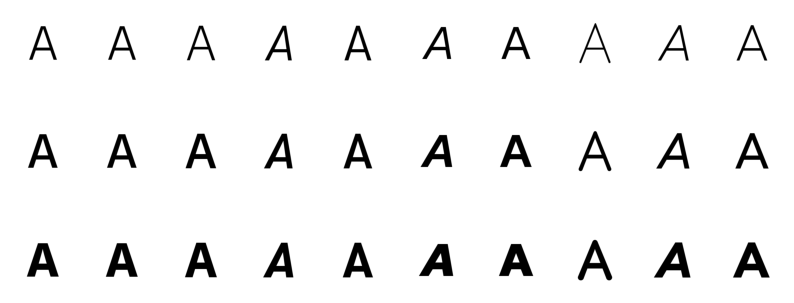

Light Regular Bold
s - m 1167.918352526195
m - l 2747.4032990974147


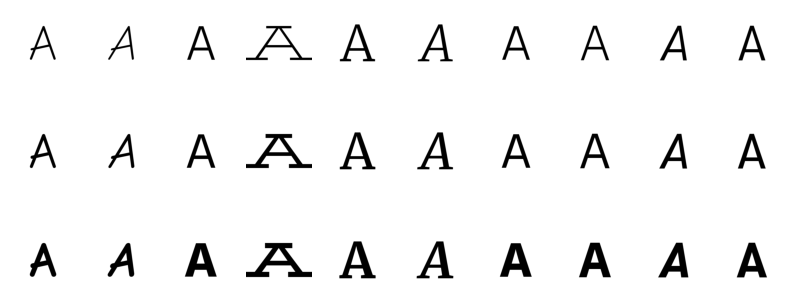

In [46]:
def calc(font1, font2):
    path1 = '../font2img/image/' + font1 + '/A.png'
    path2 = '../font2img/image/' + font2 + '/A.png'
    img1 = cv2.imread(path1, 0)/255.0
    img2 = cv2.imread(path2, 0)/255.0
    return np.sum(np.abs(img1 - img2))

def ahi(small, medium, large):
    print(small, medium, large)
    s_and_m = 0.
    m_and_l = 0.

    if medium == 'Medium':
        df = pd.read_csv('csv_files/weight_interpolation.csv')
    elif medium == 'Regular':
        df = pd.read_csv('csv_files/weight_interpolation_LRB.csv')

    for _, font in df.iterrows():
        s_and_m += calc(font[small], font[medium])
        m_and_l += calc(font[medium], font[large])

    s_and_m /= len(path_list)
    m_and_l /= len(path_list)

    print('s - m', s_and_m)
    print('m - l', m_and_l)

    fig, ax = plt.subplots(3, 10, figsize=(10, 4))

    for i in range(10):
        ax[0, i].imshow(cv2.imread('../font2img/image/' + df.loc[i, small] + '/A.png', 0), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(cv2.imread('../font2img/image/' + df.loc[i, medium] + '/A.png', 0), cmap='gray')
        ax[1, i].axis('off')
        ax[2, i].imshow(cv2.imread('../font2img/image/' + df.loc[i, large] + '/A.png', 0), cmap='gray')
        ax[2, i].axis('off')

    plt.show()

ahi('Light', 'Medium', 'Bold')
ahi('Light', 'Regular', 'Bold')

In [ ]:
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
output_dict = {'style1': [], 'style2': [], 'data_type': [],}

# 189
# serif 42
# sans-serif 122
# display 19
# handwriting 6
# Light 141 - Regular 866 - Bold 268
# LightItalic 54 - Italic 131 - BoldItalic 95
# small = 'Light'
# medium = 'Regular'
# large = 'Bold'

# 134
# serif 28
# sans-serif 99
# display 5
# handwriting 2
# Light 141 - Medium 121 - Bold 268
# LightItalic 54 - MediumItalic 44 - BoldItalic 95
small = 'Light'
medium = 'Medium'
large = 'Bold'

path_list = []
for data_type in ['train', 'valid', 'test']:
    data_type_df = df[df['data_type'] == data_type].reset_index(drop=True)

    for _, row in data_type_df.iterrows():
        font = row['font']
        category = row['category']

        if small not in font:
            continue
        if os.path.exists('../font2img/image/' + font) == False:
            continue

        medium_font = font.replace(small, medium)
        large_font = font.replace(small, large)

        if medium == 'Regular' and 'Italic' in font:
            medium_font = font.replace(small, '') # LightItalic -> Italic

        if os.path.exists('../font2img/image/' + medium_font) == False or os.path.exists('../font2img/image/' + large_font) == False:
            continue

        path_list.append({small: font, medium: medium_font, large: large_font, 'category': category})

print(len(path_list))

output_filename = 'csv_files/weight_interpolation.csv'
output_df = pd.DataFrame(path_list)
output_df.to_csv(output_filename, index=False)